# 0. Overview of Model Pipeline

### MedModel V17 pipeline
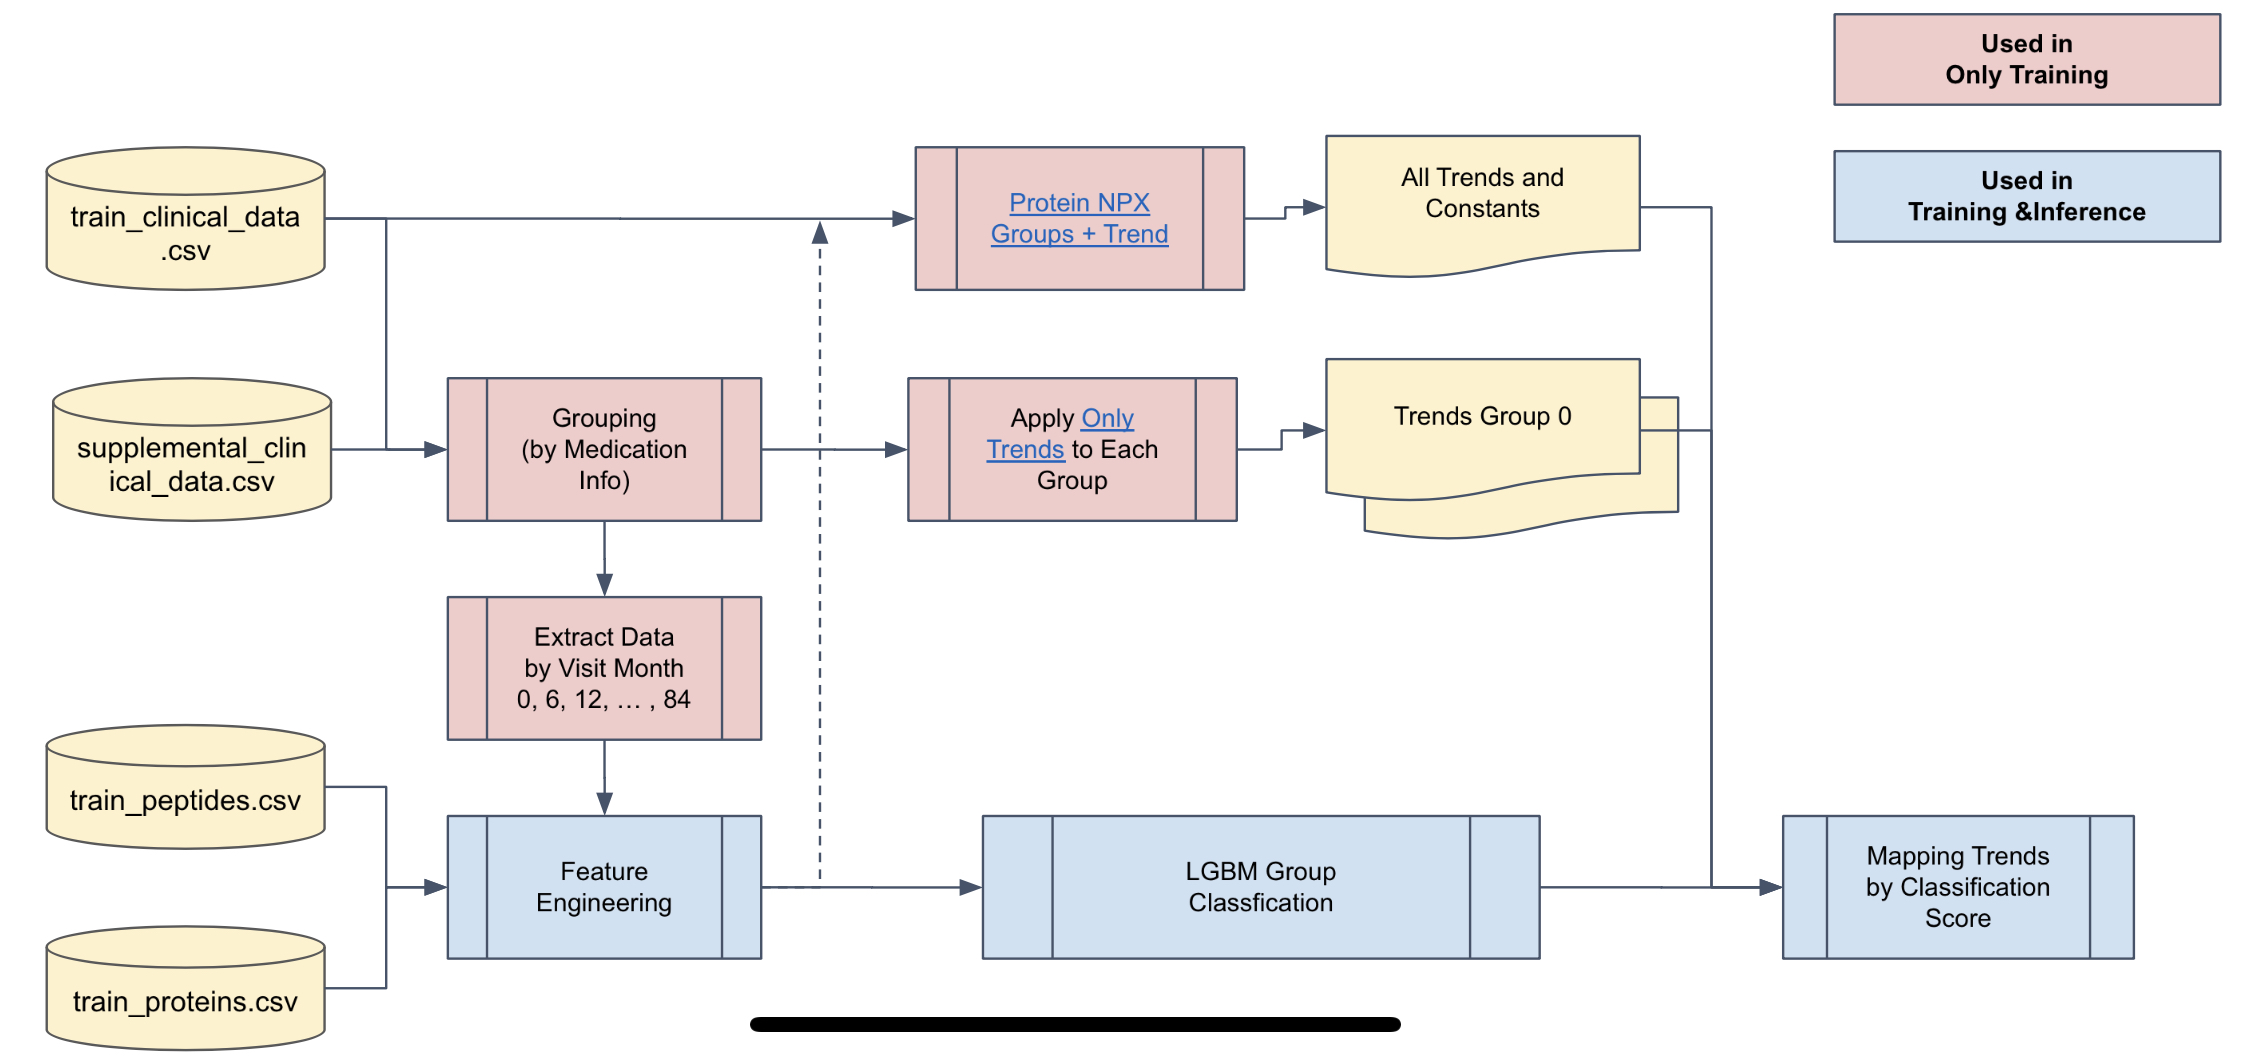
**note**
1. Curretly, making constant is done in the other [notebook](https://www.kaggle.com/code/maruichi01/create-constant-groupopt) and merged in f009_shift_protein in feture engineering.
1. Grouping is done in this [notebook](https://www.kaggle.com/code/maruichi01/create-constant-groupopt?scriptVersionId=129454430).

# 1. Import library/simulator classes

In [ ]:
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import amp_pd_peptide

import pickle
from tqdm.auto import tqdm
from dataclasses import dataclass
from typing import Optional, Dict, List

In [ ]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

In [ ]:
def smape_plus(y_true, y_pred):

    """
    Calculate symmetric mean absolute percentage error from given ground-truth and predictions
    
    Parameters
    ----------
    y_true: array-like of shape (n_samples)
        Array of ground-truth values
        
    y_pred: array-like of shape (n_samples)
        Array of prediction values
        
    Returns
    -------
    smape: float
        Symmetric mean absolute percentage error
    """
    y_true = y_true + 1
    y_pred = y_pred + 1

    smape = 100 / len(y_true ) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

    return smape

In [ ]:
'''
An unlocked version of the timeseries API intended for testing alternate inputs.
Mirrors the production timeseries API in the crucial respects, but won't be as fast.

ONLY works afer the first three variables in MockAPI.__init__ are populated.
'''

from typing import Sequence, Tuple


class MockApi:
    def __init__(self, input_dir: str = '/kaggle/input/'):
        '''
        YOU MUST UPDATE THE FIRST THREE LINES of this method.
        They've been intentionally left in an invalid state.

        Variables to set:
            input_paths: a list of two or more paths to the csv files to be served
            group_id_column: the column that identifies which groups of rows the API should serve.
                A call to iter_test serves all rows of all dataframes with the current group ID value.
            export_group_id_column: if true, the dataframes iter_test serves will include the group_id_column values.
        '''
        self.input_paths: Sequence[str] = [
            os.path.join(input_dir, "amp-parkinsons-disease-progression-prediction", "train_clinical_data.csv"),
            os.path.join(input_dir, "amp-parkinsons-disease-progression-prediction", "train_peptides.csv"),
            os.path.join(input_dir, "amp-parkinsons-disease-progression-prediction", "train_proteins.csv")
        ]

        self.group_id_column: str = "visit_month"
        self.export_group_id_column: bool = True
        # iter_test is only designed to support at least two dataframes, such as test and sample_submission
        assert len(self.input_paths) >= 2

        self._status = 'initialized'
        self.predictions = []

    def iter_test(self) -> Tuple[pd.DataFrame]:
        '''
        Loads all of the dataframes specified in self.input_paths,
        then yields all rows in those dataframes that equal the current self.group_id_column value.
        '''
        if self._status != 'initialized':

            raise Exception('WARNING: the real API can only iterate over `iter_test()` once.')

        dataframes = []
        for pth in self.input_paths:
            df = pd.read_csv(pth, low_memory=False)
            if os.path.basename(pth) == "train_clinical_data.csv":
                # submissionの作成 : updrs_testとして正解ラベルも含める
                df = pd.read_csv(pth, low_memory=False)
                df["row_id_1"] = df["visit_id"]+"_updrs_1"
                df["row_id_2"] = df["visit_id"]+"_updrs_2"
                df["row_id_3"] = df["visit_id"]+"_updrs_3"
                df["row_id_4"] = df["visit_id"]+"_updrs_4"
                r1 = ["visit_id", "patient_id", "visit_month", "updrs_1", "row_id_1", "upd23b_clinical_state_on_medication"]
                r2 = ["visit_id", "patient_id", "visit_month", "updrs_2", "row_id_2", "upd23b_clinical_state_on_medication"]
                r3 = ["visit_id", "patient_id", "visit_month", "updrs_3", "row_id_3", "upd23b_clinical_state_on_medication"]
                r4 = ["visit_id", "patient_id", "visit_month", "updrs_4", "row_id_4", "upd23b_clinical_state_on_medication"]
                df = pd.concat([
                    df.loc[:, r1].rename(columns={"updrs_1":"updrs_test", "row_id_1":"row_id"}),
                    df.loc[:, r2].rename(columns={"updrs_2":"updrs_test", "row_id_2":"row_id"}),
                    df.loc[:, r3].rename(columns={"updrs_3":"updrs_test", "row_id_3":"row_id"}), 
                    df.loc[:, r4].rename(columns={"updrs_4":"updrs_test", "row_id_4":"row_id"})])
                df_submission = []
                for row_id in df["row_id"]:
                    for plus in [0, 6, 12, 24]:
                        df_submission.append(f"{row_id}_plus_{plus}_months")
                df_submission = pd.DataFrame(df_submission, columns=["prediction_id"])
                df_submission["rating"] = 0
                pattern = r'(\d+_\d+)'
                df_submission["visit_id"] = df_submission["prediction_id"].str.extract(pattern)
                df_submission['visit_month'] = df_submission.apply('prediction_id').str.split('_', expand=True)[1].astype(int)
                dataframes.append(df_submission)
            dataframes.append(df)
        # change dataframe order       
        dataframes = [dataframes[1], dataframes[2], dataframes[3], dataframes[0]] #df_test, df_test_peptides, df_test_proteins, df_submission
        # Testに登場するvisit_idのリストに限定
        group_order = [0, 6, 12, 18, 24 , 36, 48, 60, 72, 84]
        dataframes = [df.set_index(self.group_id_column) for df in dataframes]

        for group_id in group_order:
            self._status = 'prediction_needed'
            current_data = []
            for df in dataframes:
                try:
                    cur_df = df.loc[group_id].copy()
                    # returning single line dataframes from df.loc requires special handling
                    if not isinstance(cur_df, pd.DataFrame):
                        cur_df = pd.DataFrame({a: b for a, b in zip(cur_df.index.values, cur_df.values)}, index=[group_id])
                        cur_df.index.name = self.group_id_column
                    cur_df = cur_df.reset_index(drop=not(self.export_group_id_column))
                    current_data.append(cur_df)
                except:
                    current_data.append(pd.DataFrame())
            # visit_idが存在しないデータはyieldしない       
            if current_data[0].shape != (0, 0):
                yield tuple(current_data)
                while self._status != 'prediction_received':
                    print('You must call `predict()` successfully before you can continue with `iter_test()`', flush=True)
                    yield None

#         with open('submission.csv', 'w') as f_open:
#             pd.concat(self.predictions).to_csv(f_open, index=False)
        self._status = 'finished'

    def predict(self, user_predictions: pd.DataFrame):
        '''
        Accepts and stores the user's predictions and unlocks iter_test once that is done
        '''
        if self._status == 'finished':
            raise Exception('You have already made predictions for the full test set.')
        if self._status != 'prediction_needed':
            raise Exception('You must get the next test sample from `iter_test()` first.')
        if not isinstance(user_predictions, pd.DataFrame):
            raise Exception('You must provide a DataFrame.')

        self.predictions.append(user_predictions)
        self._status = 'prediction_received'

def make_env(input_dir: str=None):
    if input_dir is None:
        return MockApi()
    else:
        return MockApi(input_dir)

# 2. Feature engineering

## 2-1.Feature generation functions

In [ ]:
# Preprocessing of peptides and proteins
import re
from collections import Counter
from Bio.SeqUtils import molecular_weight

def peptide_clean(peptide):
    # Remove modifications from the peptide sequence
    cleaned_peptide = re.sub(r'\(UniMod_4\)', '', peptide)
    cleaned_peptide = re.sub(r'\(UniMod_35\)', '', cleaned_peptide)
    return cleaned_peptide

def peptide_length(peptide):
    return len(peptide_clean(peptide))

def count_mod4(peptide, modification='UniMod_4'):
    return peptide.count(modification)

def count_mod35(peptide, modification='UniMod_35'):
    return peptide.count(modification)

def amino_acid_composition(peptide):    
    # Calculate the count of each amino acid in the cleaned peptide
    aa_count = Counter(peptide_clean(peptide))
    
    # Normalize the count by the length of the cleaned peptide to get the relative composition
    composition = {aa: aa_count[aa] / len(peptide_clean(peptide)) for aa in aa_count}
    
    return composition

def peptide_molecular_weight(peptide):
    return molecular_weight(peptide_clean(peptide), seq_type='protein')

def sequence_motifs(peptide, motifs=['GAVVT', 'VGGAV', 'KTKEG', 'VLYVG', 'DVVTG', 'TAGWV', 'AEAEE', 'GDKYG', 'LGGVF', 'LPGYP']):
    motifs = [
        r'P..P',
        r'PP.Y',
        r'K[KR].{0,1}[KR]',
        r'L..L.L',
        r'R..[ST]',
        r'[RK]..[ST]',
        r'[ST]P'
    ]

    motif_count = {f'motif_{i + 1}': len(re.findall(motif, peptide_clean(peptide))) for i, motif in enumerate(motifs)}
    return motif_count

@dataclass
class ENV:
    UNIPROT = ['O00391', 'O00533', 'O00584', 'O14498', 'O14773', 'O14791', 'O15240', 'O15394', 'O43505', 'O60888', 'O75144', 'O75326', 'O94919', 'P00441', 'P00450', 'P00734', 'P00736', 'P00738', 'P00746', 'P00747', 'P00748', 'P00751', 'P01008', 'P01009', 'P01011', 'P01019', 'P01023', 'P01024', 'P01031', 'P01033', 'P01034', 'P01042', 'P01344', 'P01591', 'P01594', 'P01608', 'P01621', 'P01717', 'P01780', 'P01833', 'P01834', 'P01857', 'P01859', 'P01860', 'P01861', 'P01876', 'P01877', 'P02452', 'P02647', 'P02649', 'P02652', 'P02655', 'P02656', 'P02671', 'P02675', 'P02679', 'P02747', 'P02748', 'P02749', 'P02750', 'P02751', 'P02753', 'P02760', 'P02763', 'P02765', 'P02766', 'P02768', 'P02774', 'P02787', 'P02790', 'P02792', 'P04004', 'P04075', 'P04156', 'P04180', 'P04196', 'P04207', 'P04211', 'P04216', 'P04217', 'P04275', 'P04406', 'P04433', 'P05060', 'P05067', 'P05090', 'P05155', 'P05156', 'P05408', 'P05452', 'P05546', 'P06310', 'P06396', 'P06454', 'P06681', 'P06727', 'P07195', 'P07225', 'P07333', 'P07339', 'P07602', 'P07711', 'P07858', 'P07998', 'P08123', 'P08133', 'P08253', 'P08294', 'P08493', 'P08571', 'P08603', 'P08637', 'P08697', 'P09104', 'P09486', 'P09871', 'P10451', 'P10643', 'P10645', 'P10909', 'P11142', 'P11277', 'P12109', 'P13473', 'P13521', 'P13591', 'P13611', 'P13671', 'P13987', 'P14174', 'P14314', 'P14618', 'P16035', 'P16070', 'P16152', 'P16870', 'P17174', 'P17936', 'P18065', 'P19021', 'P19652', 'P19823', 'P19827', 'P20774', 'P20933', 'P23083', 'P23142', 'P24592', 'P25311', 'P27169', 'P30086', 'P31997', 'P32754', 'P35542', 'P36222', 'P36955', 'P36980', 'P39060', 'P40925', 'P41222', 'P43121', 'P43251', 'P43652', 'P49588', 'P49908', 'P51884', 'P54289', 'P55290', 'P60174', 'P61278', 'P61626', 'P61769', 'P61916', 'P80748', 'P98160', 'Q02818', 'Q06481', 'Q08380', 'Q12805', 'Q12841', 'Q12907', 'Q13283', 'Q13332', 'Q13449', 'Q13451', 'Q13740', 'Q14118', 'Q14508', 'Q14515', 'Q14624', 'Q15904', 'Q16270', 'Q16610', 'Q562R1', 'Q6UX71', 'Q6UXB8', 'Q6UXD5', 'Q7Z3B1', 'Q7Z5P9', 'Q8IWV7', 'Q8N2S1', 'Q8NBJ4', 'Q8NE71', 'Q92520', 'Q92823', 'Q92876', 'Q96BZ4', 'Q96KN2', 'Q96PD5', 'Q96S96', 'Q99435', 'Q99674', 'Q99683', 'Q99829', 'Q99832', 'Q99969', 'Q9BY67', 'Q9HDC9', 'Q9NQ79', 'Q9NYU2', 'Q9UBR2', 'Q9UBX5', 'Q9UHG2', 'Q9UKV8', 'Q9UNU6', 'Q9Y646', 'Q9Y6R7']
    PEPTIDE = ['AADDTWEPFASGK', 'AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K', 'AAFTEC(UniMod_4)C(UniMod_4)QAADK', 'AANEVSSADVK', 'AATGEC(UniMod_4)TATVGKR', 'AATVGSLAGQPLQER', 'AAVYHHFISDGVR', 'ADDKETC(UniMod_4)FAEEGK', 'ADDKETC(UniMod_4)FAEEGKK', 'ADDLGKGGNEESTKTGNAGSR', 'ADLSGITGAR', 'ADQVC(UniMod_4)INLR', 'ADRDQYELLC(UniMod_4)LDNTR', 'ADSGEGDFLAEGGGVR', 'AEAQEAEDQQAR', 'AEFAEVSK', 'AELQC(UniMod_4)PQPAA', 'AESPEVC(UniMod_4)FNEESPK', 'AFPALTSLDLSDNPGLGER', 'AGAAAGGPGVSGVC(UniMod_4)VC(UniMod_4)K', 'AGALNSNDAFVLK', 'AGC(UniMod_4)VAESTAVC(UniMod_4)R', 'AGDFLEANYMNLQR', 'AGKEPGLQIWR', 'AGLAASLAGPHSIVGR', 'AGLLRPDYALLGHR', 'AGLQVYNK', 'AIGAVPLIQGEYMIPC(UniMod_4)EK', 'AIGYLNTGYQR', 'AIPVTQYLK', 'AIQLTYNPDESSKPNMIDAATLK', 'AKAYLEEEC(UniMod_4)PATLRK', 'AKLEEQAQQIR', 'AKPALEDLR', 'AKWEMPFDPQDTHQSR', 'ALANSLAC(UniMod_4)QGK', 'ALDFAVGEYNK', 'ALEQDLPVNIK', 'ALEYIENLR', 'ALFLETEQLK', 'ALGISPFHEHAEVVFTANDSGPR', 'ALGISPFHEHAEVVFTANDSGPRR', 'ALMSPAGMLR', 'ALPGTPVASSQPR', 'ALQDQLVLVAAK', 'ALSIGFETC(UniMod_4)R', 'ALSSEWKPEIR', 'ALTDMPQMR', 'ALVQQMEQLR', 'ALYLQYTDETFR', 'ANAGKPKDPTFIPAPIQAK', 'ANRPFLVFIR', 'APEAQVSVQPNFQQDK', 'APHGPGLIYR', 'APLIPMEHC(UniMod_4)TTR', 'AQAGANTRPC(UniMod_4)PS', 'AQC(UniMod_4)GGGLLGVR', 'AQGFTEDTIVFLPQTDK', 'AQPVQVAEGSEPDGFWEALGGK', 'AQTTVTC(UniMod_4)M(UniMod_35)ENGWSPTPR', 'AQTTVTC(UniMod_4)MENGWSPTPR', 'ARAEAQEAEDQQAR', 'ASEGGFTATGQR', 'ASGSPEPAISWFR', 'ASHEEVEGLVEK', 'ASLVPMEHC(UniMod_4)ITR', 'ASNLESGVPSR', 'ASQSVSSYLAWYQQKPGQAPR', 'ASVGQDSPEPR', 'ASYGVKPR', 'ASYLDC(UniMod_4)IR', 'ATEDEGSEQKIPEATNR', 'ATEDEGSEQKIPEATNRR', 'ATEHLSTLSEK', 'ATFGC(UniMod_4)HDGYSLDGPEEIEC(UniMod_4)TK', 'ATLGPAVRPLPWQR', 'ATTVTGTPC(UniMod_4)QDWAAQEPHR', 'ATVNPSAPR', 'ATVVYQGER', 'ATWSGAVLAGR', 'AVC(UniMod_4)SQEAMTGPC(UniMod_4)R', 'AVDTWSWGER', 'AVGDKLPEC(UniMod_4)EADDGC(UniMod_4)PKPPEIAHGYVEHSVR', 'AVISPGFDVFAK', 'AVLPTGDVIGDSAK', 'AVSEKEVDSGNDIYGNPIKR', 'AVVFLEPQWYR', 'AVVVHAGEDDLGR', 'AYKSELEEQLTPVAEETR', 'AYLEEEC(UniMod_4)PATLR', 'AYLEEEC(UniMod_4)PATLRK', 'AYQGVAAPFPK', 'C(UniMod_4)AEENC(UniMod_4)FIQK', 'C(UniMod_4)APFFYGGC(UniMod_4)GGNR', 'C(UniMod_4)C(UniMod_4)AAADPHEC(UniMod_4)YAK', 'C(UniMod_4)C(UniMod_4)ESASEDC(UniMod_4)MAK', 'C(UniMod_4)C(UniMod_4)ESASEDC(UniMod_4)MAKELPEHTVK', 'C(UniMod_4)C(UniMod_4)TESLVNR', 'C(UniMod_4)C(UniMod_4)VEC(UniMod_4)PPC(UniMod_4)PAPPVAGPSVFLFPPKPK', 'C(UniMod_4)DSSPDSAEDVRK', 'C(UniMod_4)FLAFTQTK', 'C(UniMod_4)FSGQC(UniMod_4)ISK', 'C(UniMod_4)IIEVLSNALSK', 'C(UniMod_4)KPVNTFVHEPLVDVQNVC(UniMod_4)FQEK', 'C(UniMod_4)LAFEC(UniMod_4)PENYR', 'C(UniMod_4)LAFEC(UniMod_4)PENYRR', 'C(UniMod_4)LAPLEGAR', 'C(UniMod_4)LKDGAGDVAFVK', 'C(UniMod_4)LPVTAPENGK', 'C(UniMod_4)LVEKGDVAFVK', 'C(UniMod_4)LVEKGDVAFVKHQTVPQNTGGK', 'C(UniMod_4)LVNLIEK', 'C(UniMod_4)MC(UniMod_4)PAENPGC(UniMod_4)R', 'C(UniMod_4)NLLAEK', 'C(UniMod_4)PFPSRPDNGFVNYPAKPTLYYK', 'C(UniMod_4)PNPPVQENFDVNK', 'C(UniMod_4)PNPPVQENFDVNKYLGR', 'C(UniMod_4)QC(UniMod_4)DELC(UniMod_4)SYYQSC(UniMod_4)C(UniMod_4)TDYTAEC(UniMod_4)KPQVTR', 'C(UniMod_4)RDQLPYIC(UniMod_4)QFGIV', 'C(UniMod_4)REILSVDC(UniMod_4)STNNPSQAK', 'C(UniMod_4)STSSLLEAC(UniMod_4)TFR', 'C(UniMod_4)SYTEDAQC(UniMod_4)IDGTIEVPK', 'C(UniMod_4)TSTGWIPAPR', 'C(UniMod_4)TTPPPSSGPTYQC(UniMod_4)LK', 'C(UniMod_4)VC(UniMod_4)PVSNAMC(UniMod_4)R', 'C(UniMod_4)VDVDEC(UniMod_4)APPAEPC(UniMod_4)GK', 'C(UniMod_4)VNHYGGYLC(UniMod_4)LPK', 'C(UniMod_4)YTAVVPLVYGGETK', 'DAC(UniMod_4)GC(UniMod_4)C(UniMod_4)PMC(UniMod_4)AR', 'DALSSVQESQVAQQAR', 'DASGVTFTWTPSSGK', 'DC(UniMod_4)GSVDGVIKEVNVSPC(UniMod_4)PTQPC(UniMod_4)QLSK', 'DC(UniMod_4)HLAQVPSHTVVAR', 'DC(UniMod_4)SLPYATESK', 'DDKETC(UniMod_4)FAEEGKK', 'DDNPNLPR', 'DEPPQSPWDR', 'DFADIPNLR', 'DGAGDVAFVK', 'DGGFC(UniMod_4)EVC(UniMod_4)K', 'DGGFC(UniMod_4)EVC(UniMod_4)KK', 'DGLKYHYLIR', 'DGWSAQPTC(UniMod_4)IK', 'DIPMNPMC(UniMod_4)IYR', 'DKETC(UniMod_4)FAEEGKK', 'DKLAAC(UniMod_4)LEGNC(UniMod_4)AEGLGTNYR', 'DLATVYVDVLK', 'DLEDETLWVEER', 'DLGEENFK', 'DLLFKDSAHGFLK', 'DLLFRDDTVC(UniMod_4)LAK', 'DLLLPQPDLR', 'DMPASEDLQDLQK', 'DNC(UniMod_4)C(UniMod_4)ILDER', 'DNWVFC(UniMod_4)GGK', 'DPTFIPAPIQAK', 'DQC(UniMod_4)QVDSQC(UniMod_4)PGQMK', 'DQGNQEQDPNISNGEEEEEKEPGEVGTHNDNQER', 'DQPFTILYR', 'DQTVSDNELQEM(UniMod_35)SNQGSK', 'DQTVSDNELQEMSNQGSK', 'DRLDEVKEQVAEVR', 'DSGEGDFLAEGGGVR', 'DSGFQM(UniMod_35)NQLR', 'DSGFQMNQLR', 'DSGRDYVSQFEGSALGK', 'DSGVPDRFSGSGSGTDFTLK', 'DTDTGALLFIGK', 'DTINLLDQR', 'DTSC(UniMod_4)VNPPTVQNAYIVSR', 'DTVIKPLLVEPEGLEK', 'DVC(UniMod_4)KNYAEAK', 'DVLLEAC(UniMod_4)C(UniMod_4)ADGHR', 'DVQLVESGGGLVKPGGSLR', 'DVRDYFMPC(UniMod_4)PGR', 'DWHGVPGQVDAAMAGR', 'DYFMPC(UniMod_4)PGR', 'DYVSQFEGSALGK', 'EAEEETTNDNGVLVLEPARK', 'EAEEHQETQC(UniMod_4)LR', 'EALQGVGDMGR', 'EC(UniMod_4)EEIIR', 'EDC(UniMod_4)NELPPRR', 'EDSLEAGLPLQVR', 'EFQLFSSPHGK', 'EFTRPEEIIFLR', 'EGDMLTLFDGDGPSAR', 'EGQEC(UniMod_4)GVYTPNC(UniMod_4)APGLQC(UniMod_4)HPPKDDEAPLR', 'EGTC(UniMod_4)PEAPTDEC(UniMod_4)KPVK', 'EGVQKEDIPPADLSDQVPDTESETR', 'EGYYGYTGAFR', 'EHVAHLLFLR', 'EIGELYLPK', 'EILSVDC(UniMod_4)STNNPSQAK', 'EIQNAVNGVK', 'EIVLTQSPATLSLSPGER', 'EIVMTQSPATLSVSPGER', 'EKLQDEDLGFL', 'ELDESLQVAER', 'ELDLNSVLLK', 'ELLESYIDGR', 'ELQQAVLHMEQR', 'ELSSFIDKGQELC(UniMod_4)ADYSENTFTEYK', 'ELSSFIDKGQELC(UniMod_4)ADYSENTFTEYKK', 'EPGLC(UniMod_4)TWQSLR', 'EPQVYTLPPSRDELTK', 'EPTMYGEILSPNYPQAYPSEVEK', 'EQLSLLDRFTEDAKR', 'EQLTPLIK', 'EQPPSLTR', 'EQWPQC(UniMod_4)PTIK', 'ESAYLYAR', 'ESLQQMAEVTR', 'ESLSSYWESAK', 'ETLLQDFR', 'ETYGEMADC(UniMod_4)C(UniMod_4)AK', 'EVGPTNADPVC(UniMod_4)LAK', 'EVNVSPC(UniMod_4)PTQPC(UniMod_4)QLSK', 'EVPLNTIIFMGR', 'EVQPVELPNC(UniMod_4)NLVK', 'EVVEEAENGR', 'EVVSLTEAC(UniMod_4)C(UniMod_4)AEGADPDC(UniMod_4)YDTR', 'EWVAIESDSVQPVPR', 'EYC(UniMod_4)GVPGDGDEELLR', 'FAALDNEEEDK', 'FAEQDAK', 'FDEFFSEGC(UniMod_4)APGSK', 'FDEFFSEGC(UniMod_4)APGSKK', 'FDGILGMAYPR', 'FEHC(UniMod_4)NFNDVTTR', 'FFLC(UniMod_4)QVAGDAK', 'FIYGGC(UniMod_4)GGNR', 'FKDLGEENFK', 'FLATTPNSLLVSWQPPR', 'FLC(UniMod_4)TGGVSPYADPNTC(UniMod_4)R', 'FLENEDR', 'FLENEDRR', 'FLNVLSPR', 'FLPSYQAVEYMR', 'FLVNLVK', 'FM(UniMod_35)ETVAEK', 'FMETVAEK', 'FMQAVTGWK', 'FNALQYLR', 'FNKNNEGTYYSPNYNPQSR', 'FNKPFVFLM(UniMod_35)IEQNTK', 'FQNALLVR', 'FQPTLLTLPR', 'FQSVFTVTR', 'FSALEVDETYVPK', 'FSC(UniMod_4)FQEEAPQPHYQLR', 'FSC(UniMod_4)MC(UniMod_4)PQGYQVVR', 'FSEEAC(UniMod_4)AVLTSPTFEAC(UniMod_4)HR', 'FSGSLLGGK', 'FSGSNSGNTATLTISR', 'FSGTWYAMAK', 'FSPATHPSEGLEENYC(UniMod_4)RNPDNDPQGPWC(UniMod_4)YTTDPEKR', 'FSVVYAK', 'FTDSENVC(UniMod_4)QER', 'FTEC(UniMod_4)C(UniMod_4)QAADK', 'FTFEYSR', 'FTILDSQGK', 'FTNIGPDTMR', 'FTQVTPTSLSAQWTPPNVQLTGYR', 'FVEGLPINDFSR', 'FVVTDGGITR', 'FYNQVSTPLLR', 'FYVHNDIFR', 'GAAPPKQEFLDIEDP', 'GALQNIIPASTGAAK', 'GAQTLYVPNC(UniMod_4)DHR', 'GAQTQTEEEMTR', 'GATLALTQVTPQDER', 'GATTSPGVYELSSR', 'GAYPLSIEPIGVR', 'GC(UniMod_4)PTEEGC(UniMod_4)GER', 'GC(UniMod_4)SFLPDPYQK', 'GDFSSANNRDNTYNR', 'GDKVWVYPPEKK', 'GEAAGAVQELAR', 'GEAGAPGEEDIQGPTK', 'GEC(UniMod_4)WC(UniMod_4)VNPNTGK', 'GEVQAMLGQSTEELR', 'GEVQAMLGQSTEELRVR', 'GGETSEMYLIQPDSSVKPYR', 'GGSTSYGTGSETESPR', 'GGTLGTPQTGSENDALYEYLR', 'GINVALANGK', 'GIVEEC(UniMod_4)C(UniMod_4)FR', 'GIYGTISR', 'GKRPYQEGTPC(UniMod_4)SQC(UniMod_4)PSGYHC(UniMod_4)K', 'GLEFLSVPSTYYK', 'GLETSLAEC(UniMod_4)TFTK', 'GLGEISAASEFK', 'GLPAPIEK', 'GLSAEPGWQAK', 'GLVSWGNIPC(UniMod_4)GSK', 'GLYDVVSVLR', 'GMADQDGLKPTIDKPSEDSPPLEMLGPR', 'GMDSC(UniMod_4)KGDSGGAFAVQDPNDKTK', 'GMFNIQHC(UniMod_4)K', 'GNPEPTFSWTK', 'GNQWVGYDDQESVK', 'GNSYFMVEVK', 'GPSVFPLAPSSK', 'GQEDASPDRFSNTDYAVGYMLR', 'GQSISVTSIRPC(UniMod_4)AAETQ', 'GRPGPQPWC(UniMod_4)ATTPNFDQDQR', 'GRTC(UniMod_4)PKPDDLPFSTVVPLK', 'GSESGIFTNTK', 'GSFAC(UniMod_4)QC(UniMod_4)PPGYQK', 'GSGGLNLGNFFASR', 'GSLVAPDR', 'GSPAINVAVHVFR', 'GSPAINVAVHVFRK', 'GSPSGEVSHPR', 'GSQTQSHPDLGTEGC(UniMod_4)WDQLSAPR', 'GVALADFNR', 'GVASLFAGR', 'GWVTDGFSSLK', 'GYC(UniMod_4)APGMEC(UniMod_4)VK', 'GYHLNEEGTR', 'GYPGVQAPEDLEWER', 'GYQLSDVDGVTC(UniMod_4)EDIDEC(UniMod_4)ALPTGGHIC(UniMod_4)SYR', 'GYTQQLAFR', 'HGGLYHENMR', 'HGNVAEGETKPDPDVTER', 'HGPGLIYR', 'HGSPVDIC(UniMod_4)TAKPR', 'HGTC(UniMod_4)AAQVDALNSQKK', 'HKVYAC(UniMod_4)EVTHQGLSSPVTK', 'HLDSVLQQLQTEVYR', 'HLSLLTTLSNR', 'HNC(UniMod_4)MENSIC(UniMod_4)R', 'HPDEAAFFDTASTGK', 'HPNSPLDEENLTQENQDR', 'HPNVFGFC(UniMod_4)R', 'HQFLLTGDTQGR', 'HQPQEFPTYVEPTNDEIC(UniMod_4)EAFR', 'HQPQEFPTYVEPTNDEIC(UniMod_4)EAFRK', 'HQPQEFPTYVEPTNDEIC(UniMod_4)EAFRKDPK', 'HQTVPQNTGGKNPDPWAK', 'HRLEDMEQALSPSVFK', 'HSIFTPETNPR', 'HSTIFENLANK', 'HTFM(UniMod_35)GVVSLGSPSGEVSHPR', 'HTFMGVVSLGSPSGEVSHPR', 'HTSVQTTSSGSGPFTDVR', 'HVEPGEPLAPSPQEPQAVGR', 'HVLFGTVGVPEHTYR', 'HYDGSYSTFGER', 'HYEGSTVPEK', 'HYTNPSQDVTVPC(UniMod_4)PVPPPPPC(UniMod_4)C(UniMod_4)HPR', 'IALVITDGR', 'IAPQLSTEELVSLGEK', 'IASFSQNC(UniMod_4)DIYPGKDFVQPPTK', 'IC(UniMod_4)ANVFC(UniMod_4)GAGR', 'IC(UniMod_4)LEDNVLM(UniMod_35)SGVK', 'IC(UniMod_4)LEDNVLMSGVK', 'IC(UniMod_4)VGC(UniMod_4)PR', 'IDQNVEELKGR', 'IDQTVEELRR', 'IEC(UniMod_4)VSAETTEDC(UniMod_4)IAK', 'IEEELGDEAR', 'IEIPSSVQQVPTIIK', 'IEKVEHSDLSFSK', 'IFFYDSENPPASEVLR', 'IFSFDGKDVLR', 'IGADFLAR', 'IGDQWDKQHDMGHMMR', 'IGDTWSK', 'IHWESASLLR', 'IIGYTPDLDPETVDDAFAR', 'IIGYVISNQQITPGPAYSNR', 'IKPVFIEDANFGR', 'ILAGSADSEGVAAPR', 'ILEVVNQIQDEER', 'ILGPLSYSK', 'ILGQQVPYATK', 'ILLQGTPVAQMTEDAVDAER', 'ILTC(UniMod_4)M(UniMod_35)QGMEEIR', 'IMNGEADAMSLDGGFVYIAGK', 'INENTGSVSVTR', 'INHC(UniMod_4)RFDEFFSEGC(UniMod_4)APGSKK', 'IPIEDGSGEVVLSR', 'IPIEDGSGEVVLSRK', 'IPLNDLFR', 'IPTTFENGR', 'IPVIEPSVPELVVKPGATVTLR', 'IQPSGGTNINEALLR', 'ISASAEELR', 'ISC(UniMod_4)TIANR', 'ISHELDSASSEVN', 'ISLPESLK', 'ISLPESLKR', 'ISYGNDALMPSLTETK', 'ITGYIIK', 'ITSWMEPIVK', 'ITTTSPWMFPSR', 'ITYGETGGNSPVQEFTVPGSK', 'IVQIYKDLLR', 'IVSSAM(UniMod_35)EPDREYHFGQAVR', 'IVSSAMEPDREYHFGQAVR', 'IWDVVEK', 'IYISGMAPR', 'IYISGMAPRPSLAK', 'IYLYTLNDNAR', 'KAADDTWEPFASGK', 'KAEEEHLGILGPQLHADVGDKVK', 'KASYLDC(UniMod_4)IR', 'KATEDEGSEQKIPEATNR', 'KC(UniMod_4)C(UniMod_4)VEC(UniMod_4)PPC(UniMod_4)PAPPVAGPSVFLFPPKPK', 'KC(UniMod_4)STSSLLEAC(UniMod_4)TFR', 'KC(UniMod_4)SYTEDAQC(UniMod_4)IDGTIEVPK', 'KDSGFQM(UniMod_35)NQLR', 'KDSGFQMNQLR', 'KEC(UniMod_4)C(UniMod_4)EKPLLEK', 'KFPSGTFEQVSQLVK', 'KGGETSEMYLIQPDSSVKPYR', 'KIYPTVNC(UniMod_4)QPLGMISLMK', 'KLC(UniMod_4)MAALK', 'KLGQSLDC(UniMod_4)NAEVYVVPWEK', 'KLINDYVK', 'KLSENTDFLAPGVSSFTDSNQQESITK', 'KLSSWVLLM(UniMod_35)K', 'KLSSWVLLMK', 'KLVGYLDR', 'KLVPFATELHER', 'KLYDYC(UniMod_4)DVPQC(UniMod_4)AAPSFDC(UniMod_4)GKPQVEPK', 'KMTVTDQVNC(UniMod_4)PK', 'KNM(UniMod_35)FEFLK', 'KPAEDEWGK', 'KPALEDLR', 'KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK', 'KPVDEYKDC(UniMod_4)HLAQVPSHTVVAR', 'KPVEEYANC(UniMod_4)HLAR', 'KQELSEAEQATR', 'KQINDYVEK', 'KQINDYVEKGTQGK', 'KQTALVELVK', 'KREEAPSLRPAPPPISGGGYR', 'KSASDLTWDNLK', 'KSPELQAEAK', 'KSQPMGLWR', 'KTLLSNLEEAK', 'KTLLSNLEEAKK', 'KTSLEDFYLDEER', 'KVEQAVETEPEPELR', 'KVESELIKPINPR', 'KVLLDGVQNPR', 'KVPQVSTPTLVEVSR', 'KVTYTSQEDLVEKK', 'KYFIDFVAR', 'KYLYEIAR', 'LAAAVSNFGYDLYR', 'LAAC(UniMod_4)GPPPVAPPAAVAAVAGGAR', 'LAARLEALKENGGAR', 'LAC(UniMod_4)C(UniMod_4)VVGVC(UniMod_4)GPGLWER', 'LADGGATNQGRVEIFYR', 'LALLVDTVGPR', 'LAPLAEDVR', 'LATVGELQAAWR', 'LAVTTHGLPC(UniMod_4)LAWASAQAK', 'LAVYQAGAR', 'LC(UniMod_4)DNLSTK', 'LC(UniMod_4)MAALK', 'LC(UniMod_4)MGSGLNLC(UniMod_4)EPNNK', 'LC(UniMod_4)MGSGLNLC(UniMod_4)EPNNKEGYYGYTGAFR', 'LC(UniMod_4)QDLGPGAFR', 'LC(UniMod_4)TVATLR', 'LDELRDEGK', 'LDEVKEQVAEVR', 'LDIDSPPITAR', 'LEAGDHPVELLAR', 'LEDMEQALSPSVFK', 'LEEQAQQIR', 'LEGEAC(UniMod_4)GVYTPR', 'LEGQEEEEDNRDSSMK', 'LEPGQQEEYYR', 'LEPYADQLR', 'LETPDFQLFK', 'LFAC(UniMod_4)SNK', 'LFDSDPITVTVPVEVSR', 'LFGGNFAHQASVAR', 'LGADM(UniMod_35)EDVC(UniMod_4)GR', 'LGADMEDVC(UniMod_4)GR', 'LGC(UniMod_4)SLNQNSVPDIHGVEAPAR', 'LGEVNTYAGDLQK', 'LGMDGYR', 'LGMFNIQHC(UniMod_4)K', 'LGNQEPGGQTALK', 'LGPGMADIC(UniMod_4)K', 'LGPLVEQGR', 'LGPLVEQGRVR', 'LGQSLDC(UniMod_4)NAEVYVVPWEK', 'LGVRPSQGGEAPR', 'LHDRNTYEKYLGEEYVK', 'LHLDYIGPC(UniMod_4)K', 'LIADLGSTSITNLGFR', 'LINDYVK', 'LIVHNGYC(UniMod_4)DGR', 'LKC(UniMod_4)DEWSVNSVGK', 'LKC(UniMod_4)DEWSVNSVGKIEC(UniMod_4)VSAETTEDC(UniMod_4)IAK', 'LKDDEVAQLKK', 'LKEDAVSAAFK', 'LLAGDHPIDLLLR', 'LLC(UniMod_4)GLLAER', 'LLC(UniMod_4)QC(UniMod_4)LGFGSGHFR', 'LLDNWDSVTSTFSK', 'LLDSLPSDTR', 'LLEELVR', 'LLELTGPK', 'LLEVPEGR', 'LLIYDASK', 'LLIYDASNR', 'LLIYGATSR', 'LLPAQLPAEKEVGPPLPQEAVPLQK', 'LLRDPADASEAHESSSR', 'LMVELHNLYR', 'LNMHMNVQNGKWDSDPSGTK', 'LPPTSAHGNVAEGETKPDPDVTER', 'LPYTASSGLMAPR', 'LQAEAFQAR', 'LQDLYSIVR', 'LQPLDFKENAEQSR', 'LQSIGTENTEENRR', 'LQSLFDSPDFSK', 'LRENELTYYC(UniMod_4)C(UniMod_4)K', 'LRENELTYYC(UniMod_4)C(UniMod_4)KK', 'LRTEGDGVYTLNNEK', 'LRTEGDGVYTLNNEKQWINK', 'LSELIQPLPLER', 'LSINTHPSQKPLSITVR', 'LSITGTYDLK', 'LSKELQAAQAR', 'LSNENHGIAQR', 'LSPEDYTLK', 'LSPIYNLVPVK', 'LSPLGEEMR', 'LSSGLVTAALYGR', 'LSSWVLLM(UniMod_35)K', 'LSSWVLLMK', 'LSYEGEVTK', 'LSYTC(UniMod_4)EGGFR', 'LTASAPGYLAITK', 'LTPLYELVK', 'LVAYYTLIGASGQR', 'LVDGKGVPIPNKVIFIR', 'LVDKFLEDVKK', 'LVFFAEDVGSNK', 'LVGGPM(UniMod_35)DASVEEEGVRR', 'LVGGPMDASVEEEGVR', 'LVGGPMDASVEEEGVRR', 'LVGYLDR', 'LVMGIPTFGR', 'LVNEVTEFAK', 'LVPPMEEDYPQFGSPK', 'LVWEEAMSR', 'LVYPSC(UniMod_4)EEK', 'LYEQLSGK', 'LYGSEAFATDFQDSAAAK', 'LYGSEAFATDFQDSAAAKK', 'LYHSEAFTVNFGDTEEAKK', 'LYQQHGAGLFDVTR', 'M(UniMod_35)ADEAGSEADHEGTHSTKR', 'M(UniMod_35)ASGAANVVGPK', 'M(UniMod_35)C(UniMod_4)PQLQQYEMHGPEGLR', 'M(UniMod_35)ELERPGGNEITR', 'M(UniMod_35)LTPEHVFIHPGWK', 'M(UniMod_35)TVTDQVNC(UniMod_4)PK', 'M(UniMod_35)VQEQC(UniMod_4)C(UniMod_4)HSQLEELHC(UniMod_4)ATGISLANEQDR', 'M(UniMod_35)YLGYEYVTAIR', 'MADEAGSEADHEGTHSTKR', 'MASGAANVVGPK', 'MATLYSR', 'MC(UniMod_4)PQLQQYEMHGPEGLR', 'MC(UniMod_4)VDVNEC(UniMod_4)QR', 'MDASLGNLFAR', 'MDYPKQTQVSVLPEGGETPLFK', 'MELERPGGNEITR', 'MFTTAPDQVDKEDEDFQESNK', 'MGNFPWQVFTNIHGR', 'MKYWGVASFLQK', 'MMAVAADTLQR', 'MNFRPGVLSSR', 'MPC(UniMod_4)AELVREPGC(UniMod_4)GC(UniMod_4)C(UniMod_4)SVC(UniMod_4)AR', 'MPYEC(UniMod_4)GPSLDVC(UniMod_4)AQDER', 'MTVTDQVNC(UniMod_4)PK', 'MVQEQC(UniMod_4)C(UniMod_4)HSQLEELHC(UniMod_4)ATGISLANEQDR', 'MYLGYEYVTAIR', 'MYYSAVDPTKDIFTGLIGPM(UniMod_35)K', 'NANTFISPQQR', 'NEQEQPLGQWHLS', 'NFGYTLR', 'NFPPSQDASGDLYTTSSQLTLPATQC(UniMod_4)LAGK', 'NFPPSQDASGDLYTTSSQLTLPATQC(UniMod_4)PDGK', 'NFPSPVDAAFR', 'NGFYPATR', 'NIGEFC(UniMod_4)GK', 'NIINSDGGPYVC(UniMod_4)R', 'NILDRQDPPSVVVTSHQAPGEK', 'NILTSNNIDVK', 'NILTSNNIDVKK', 'NKFDPSLTQR', 'NKPLFFADK', 'NLAVSQVVHK', 'NLHGDGIALWYTR', 'NLNEKDYELLC(UniMod_4)LDGTR', 'NLQPASEYTVSLVAIKGNQESPK', 'NLREGTC(UniMod_4)PEAPTDEC(UniMod_4)KPVK', 'NNEGTYYSPNYNPQSR', 'NPC(UniMod_4)QDPYILTPENR', 'NPDGDVGGPWC(UniMod_4)YTTNPR', 'NPDPWAK', 'NPDSSTTGPWC(UniMod_4)YTTDPTVR', 'NQEQVSPLTLLK', 'NRDHDTFLAVR', 'NSKFEDC(UniMod_4)C(UniMod_4)QEK', 'NSLESYAFNMK', 'NSLFEYQK', 'NSPLDEENLTQENQDR', 'NSVIKVPMMNSK', 'NSWGEEWGMGGYVK', 'NTEILTGSWSDQTYPEGTQAIYK', 'NTFAEVTGLSPGVTYYFK', 'NTGIIC(UniMod_4)TIGPASR', 'NVDGVNYASITR', 'NVVYTC(UniMod_4)NEGYSLIGNPVAR', 'NWGLGGHAFC(UniMod_4)R', 'PALEDLR', 'PIVTSPYQIHFTK', 'PNHAVVTR', 'PPTSAHGNVAEGETKPDPDVTER', 'PTLVEVSR', 'QALNTDYLDSDYQR', 'QALPQVR', 'QAPGQGLEWMGR', 'QC(UniMod_4)VPTEPC(UniMod_4)EDAEDDC(UniMod_4)GNDFQC(UniMod_4)STGR', 'QDGSVDFGR', 'QELSEAEQATR', 'QEPERNEC(UniMod_4)FLQHKDDNPNLPR', 'QFTSSTSYNR', 'QGIPFFGQVR', 'QGVNDNEEGFFSAR', 'QHM(UniMod_35)DSDSSPSSSSTYC(UniMod_4)NQMMR', 'QHMDSDSSPSSSSTYC(UniMod_4)NQMMR', 'QHVVYGPWNLPQSSYSHLTR', 'QIGSVYR', 'QINDYVEK', 'QINDYVEKGTQGK', 'QKPDGVFQEDAPVIHQEMIGGLR', 'QKVEPLRAELQEGAR', 'QKWEAEPVYVQR', 'QLEWGLER', 'QLKEHAVEGDC(UniMod_4)DFQLLKLDGK', 'QLNEINYEDHK', 'QNC(UniMod_4)ELFEQLGEYK', 'QPSSAFAAFVK', 'QQETAAAETETR', 'QQLVETHMAR', 'QQTEWQSGQR', 'QQTHMLDVMQDHFSR', 'QRQEELC(UniMod_4)LAR', 'QSGLYFIKPLK', 'QSTNAYPDLR', 'QTALVELVK', 'QTHQPPAPNSLIR', 'QTQVSVLPEGGETPLFK', 'QTVSWAVTPK', 'QVVAGLNFR', 'QWAGLVEK', 'QYNVGPSVSKYPLR', 'QYTDSTFRVPVER', 'RELDESLQVAER', 'RGEQC(UniMod_4)VDIDEC(UniMod_4)TIPPYC(UniMod_4)HQR', 'RGYQLSDVDGVTC(UniMod_4)EDIDEC(UniMod_4)ALPTGGHIC(UniMod_4)SYR', 'RIPIEDGSGEVVLSRK', 'RLEAGDHPVELLAR', 'RLEGQEEEEDNRDSSMK', 'RLGMFNIQHC(UniMod_4)K', 'RLPIGSYF', 'RLYGSEAFATDFQDSAAAK', 'RNTEILTGSWSDQTYPEGTQAIYK', 'RPC(UniMod_4)FSALEVDETYVPK', 'RPDSLQHVLLPVLDR', 'RPGGEPSPEGTTGQSYNQYSQR', 'RQEC(UniMod_4)SIPVC(UniMod_4)GQDQVTVAMTPR', 'RTHLPEVFLSK', 'RTPITVVK', 'RVDTVDPPYPR', 'RVWELSK', 'RYIETDPANRDR', 'SASDLTWDNLK', 'SASDLTWDNLKGK', 'SASLHLPK', 'SC(UniMod_4)C(UniMod_4)EEQNKVNC(UniMod_4)LQTR', 'SC(UniMod_4)DIPVFMNAR', 'SC(UniMod_4)DKTHTC(UniMod_4)PPC(UniMod_4)PAPELLGGPSVFLFPPKPK', 'SC(UniMod_4)DNPYIPNGDYSPLR', 'SC(UniMod_4)DTPPPC(UniMod_4)PR', 'SC(UniMod_4)ESNSPFPVHPGTAEC(UniMod_4)C(UniMod_4)TK', 'SC(UniMod_4)SPELQQK', 'SC(UniMod_4)VGETTESTQC(UniMod_4)EDEELEHLR', 'SDDKVTLEER', 'SDVMYTDWK', 'SDVMYTDWKK', 'SDVVYTDWK', 'SDVVYTDWKK', 'SEALAVDGAGKPGAEEAQDPEGK', 'SEGLLAC(UniMod_4)GTNAR', 'SEGSSVNLSPPLEQC(UniMod_4)VPDRGQQYQGR', 'SELEEQLTPVAEETR', 'SETKDLLFRDDTVC(UniMod_4)LAK', 'SEYPSIK', 'SFNRGEC(UniMod_4)', 'SFPTYC(UniMod_4)QQK', 'SFQTGLFTAAR', 'SGEATDGARPQALPEPMQESK', 'SGELEQEEER', 'SGIEC(UniMod_4)QLWR', 'SGINC(UniMod_4)PIQK', 'SGIPIVTSPYQIHFTK', 'SGLSTGWTQLSK', 'SGNIPAGTTVDTK', 'SGSAHEYSSSPDDAIFQSLAR', 'SGSDEVQVGQQR', 'SIAQYWLGC(UniMod_4)PAPGHL', 'SIDVAC(UniMod_4)HPGYALPK', 'SILENLR', 'SIVVSPILIPENQR', 'SKEFQLFSSPHGK', 'SKVPPPRDFHINLFR', 'SLAAAAGKQELAK', 'SLAELGGHLDQQVEEFRR', 'SLAPYAQDTQEK', 'SLDFTELDVAAEK', 'SLEDLQLTHNKITK', 'SLEDQVEMLR', 'SLGEC(UniMod_4)C(UniMod_4)DVEDSTTC(UniMod_4)FNAK', 'SLGNVIMVC(UniMod_4)R', 'SLGSPSGEVSHPR', 'SLHTLFGDK', 'SLNNQIETLLTPEGSR', 'SLPSEASEQYLTK', 'SMEQNGPGLEYR', 'SNAQGIDLNR', 'SNLDEDIIAEENIVSR', 'SNSSM(UniMod_35)HITDC(UniMod_4)R', 'SNSSMHITDC(UniMod_4)R', 'SNVSDAVAQSTR', 'SPAINVAVHVFR', 'SPELQAEAK', 'SPFEQHIK', 'SPMYSIITPNILR', 'SPQGLGAFTPVVR', 'SPVDIC(UniMod_4)TAKPR', 'SPVGVQPILNEHTFC(UniMod_4)AGMSK', 'SRGPGAPC(UniMod_4)QDVDEC(UniMod_4)AR', 'SRYPVC(UniMod_4)GSDGTTYPSGC(UniMod_4)QLR', 'SSALDMENFR', 'SSFVAPLEK', 'SSGLVSNAPGVQIR', 'SSGQWQTPGATR', 'SSNLIILEEHLK', 'SSNTYTLTDVRR', 'SSPVVIDASTAIDAPSNLR', 'SSQGGSLPSEEK', 'STGGISVPGPMGPSGPR', 'STNLHDYGMLLPC(UniMod_4)GIDK', 'STSSFPC(UniMod_4)PAGHFNGFR', 'STTPDITGYR', 'SVIPSDGPSVAC(UniMod_4)VK', 'SVIPSDGPSVAC(UniMod_4)VKK', 'SVLGQLGITK', 'SVPMVPPGIK', 'SVPPSASHVAPTETFTYEWTVPK', 'SWFEPLVEDM(UniMod_35)QR', 'SYELTQPPSVSVSPGQTAR', 'SYLSMVGSC(UniMod_4)C(UniMod_4)TSASPTVC(UniMod_4)FLKER', 'SYTITGLQPGTDYK', 'TAKDALSSVQESQVAQQAR', 'TALASGGVLDASGDYR', 'TASDFITK', 'TATSEYQTFFNPR', 'TC(UniMod_4)VADESAENC(UniMod_4)DK', 'TC(UniMod_4)VADESAENC(UniMod_4)DKSLHTLFGDK', 'TDASDVKPC(UniMod_4)', 'TEGDGVYTLNNEK', 'TEHLSTLSEK', 'TEIDKPSQMQVTDVQDNSISVK', 'TELLPGDRDNLAIQTR', 'TFHEASEDC(UniMod_4)ISR', 'TFISPIK', 'TFTC(UniMod_4)TAAYPESK', 'TFTLLDPK', 'TFYEPGEEITYSC(UniMod_4)KPGYVSR', 'TFYSC(UniMod_4)TTEGR', 'TGAQELLR', 'TGDEITYQC(UniMod_4)R', 'TGTTGQSGAESGTTEPSAR', 'TGYYFDGISR', 'THLAPYSDELR', 'THLAPYSDELRQR', 'THLGEALAPLSK', 'THLPEVFLSK', 'THPHFVIPYR', 'TINPAVDHC(UniMod_4)C(UniMod_4)K', 'TKEEYGHSEVVEYYC(UniMod_4)NPR', 'TKKQELSEAEQATR', 'TLEAQLTPR', 'TLKIENVSYQDKGNYR', 'TLLSNLEEAK', 'TLLSNLEEAKK', 'TLVVHEKADDLGKGGNEESTK', 'TLYSSSPR', 'TM(UniMod_35)LLQPAGSLGSYSYR', 'TM(UniMod_35)QENSTPRED', 'TMLLQPAGSLGSYSYR', 'TMQALPYSTVGNSNNYLHLSVLR', 'TMQENSTPRED', 'TMSEVGGSVEDLIAK', 'TNFDNDIALVR', 'TNTNVNC(UniMod_4)PIEC(UniMod_4)FMPLDVQADREDSRE', 'TPC(UniMod_4)QQELDQVLER', 'TPC(UniMod_4)TVSC(UniMod_4)NIPVVSGKEC(UniMod_4)EEIIR', 'TPENYPNAGLTMNYC(UniMod_4)R', 'TPEVTC(UniMod_4)VVVDVSHEDPEVK', 'TPLGDTTHTC(UniMod_4)PR', 'TPLPPTSAHGNVAEGETKPDPDVTER', 'TPLTATLSK', 'TPSAAYLWVGTGASEAEK', 'TPSGLYLGTC(UniMod_4)ER', 'TPVSDRVTK', 'TQSSLVPALTDFVR', 'TQVNTQAEQLR', 'TQVNTQAEQLRR', 'TSAHGNVAEGETKPDPDVTER', 'TSESGELHGLTTEEEFVEGIYK', 'TSLEDFYLDEER', 'TSPVDEKALQDQLVLVAAK', 'TSTDLQVLAAR', 'TTPEPC(UniMod_4)ELDDEDFR', 'TTPPVLDSDGSFFLYSK', 'TTPPVLDSDGSFFLYSR', 'TVAAC(UniMod_4)NLPIVR', 'TVAAPSVFIFPPSDEQLK', 'TVFGTEPDMIR', 'TVQAVLTVPK', 'TVVQPSVGAAAGPVVPPC(UniMod_4)PGR', 'TYETTLEK', 'TYLGNALVC(UniMod_4)TC(UniMod_4)YGGSR', 'VAAGAFQGLR', 'VAHQLQALR', 'VAPDEHPILLTEAPLNPK', 'VASYGVKPR', 'VAVVQYSGTGQQRPER', 'VC(UniMod_4)PFAGILENGAVR', 'VC(UniMod_4)SQYAAYGEK', 'VDGALC(UniMod_4)MEK', 'VDNALQSGNSQESVTEQDSK', 'VDNALQSGNSQESVTEQDSKDSTYSLSSTLTLSK', 'VDSGNDVTDIADDGC(UniMod_4)PKPPEIAHGYVEHSVR', 'VEHSDLSFSK', 'VEKPTADAEAYVFTPNMIC(UniMod_4)AGGEK', 'VEPLRAELQEGAR', 'VEPYGENFNK', 'VFAVSHGR', 'VFNTPEGVPSAPSSLK', 'VFQEPLFYEAPR', 'VFSNGADLSGVTEEAPLK', 'VFSNGADLSGVTEEAPLKLSK', 'VGFYESDVMGR', 'VGGVQSLGGTGALR', 'VGYVSGWGR', 'VHKEDDGVPVIC(UniMod_4)QVEHPAVTGNLQTQR', 'VHTEC(UniMod_4)C(UniMod_4)HGDLLEC(UniMod_4)ADDR', 'VHTEC(UniMod_4)C(UniMod_4)HGDLLEC(UniMod_4)ADDRADLAK', 'VHVSEEGTEPEAMLQVLGPKPALPAGTEDTAKEDAANR', 'VHVSEEGTEPEAMLQVLGPKPALPAGTEDTAKEDAANRK', 'VIAVNEVGR', 'VKDISEVVTPR', 'VKDLATVYVDVLK', 'VKSPELQAEAK', 'VLDLSC(UniMod_4)NR', 'VLEPTLK', 'VLLDGVQNPR', 'VLLDQLR', 'VLNQELR', 'VLSIAQAHSPAFSC(UniMod_4)EQVR', 'VLTPTQVK', 'VMDKYTFELSR', 'VMPIC(UniMod_4)LPSKDYAEVGR', 'VMTPAVYAPYDVK', 'VNGSPVDNHPFAGDVVFPR', 'VNHVTLSQPK', 'VPEARPNSMVVEHPEFLK', 'VPEEDLKR', 'VPFDAATLHTSTAMAAQHGMDDDGTGQK', 'VPMMSDPK', 'VPQVSTPTLVEVSR', 'VPVAVQGEDTVQSLTQGDGVAK', 'VQAAVGTSAAPVPSDNH', 'VQPYLDDFQK', 'VQPYLDDFQKK', 'VRGGEGTGYFVDFSVR', 'VRQGQGQSEPGEYEQR', 'VSEADIQR', 'VSEADSSNADWVTK', 'VSPTDC(UniMod_4)SAVEPEAEK', 'VSTLPAITLK', 'VTAAPQSVC(UniMod_4)ALR', 'VTEIWQEVMQR', 'VTEPISAESGEQVER', 'VTGVVLFR', 'VTIKPAPETEKRPQDAK', 'VTIPTDLIASSGDIIK', 'VTLTC(UniMod_4)VAPLSGVDFQLR', 'VTSIQDWVQK', 'VTTVASHTSDSDVPSGVTEVVVK', 'VVEESELAR', 'VVEQMC(UniMod_4)ITQYER', 'VVVNFAPTIQEIK', 'VYAC(UniMod_4)EVTHQGLSSPVTK', 'VYC(UniMod_4)DMNTENGGWTVIQNR', 'VYTVDLGR', 'WC(UniMod_4)AVSEHEATK', 'WEAEPVYVQR', 'WELALGR', 'WGYC(UniMod_4)LEPK', 'WKNFPSPVDAAFR', 'WLPSSSPVTGYR', 'WQEEMELYR', 'WSGQTAIC(UniMod_4)DNGAGYC(UniMod_4)SNPGIPIGTR', 'WSRPQAPITGYR', 'WSSTSPHRPR', 'WYEIEKIPTTFENGR', 'WYFDVTEGK', 'YAMVYGYNAAYNR', 'YANC(UniMod_4)HLAR', 'YFIDFVAR', 'YGFIEGHVVIPR', 'YGLDSDLSC(UniMod_4)K', 'YGLVTYATYPK', 'YGQTIRPIC(UniMod_4)LPC(UniMod_4)TEGTTR', 'YHDRDVWKPEPC(UniMod_4)R', 'YIETDPANR', 'YIFHNFMER', 'YIVSGTPTFVPYLIK', 'YKAAFTEC(UniMod_4)C(UniMod_4)QAADK', 'YLFLNGNK', 'YLGEEYVK', 'YLQEIYNSNNQK', 'YLYEIAR', 'YNSQNQSNNQFVLYR', 'YPGPQAEGDSEGLSQGLVDREK', 'YPNC(UniMod_4)AYR', 'YPSLSIHGIEGAFDEPGTK', 'YQC(UniMod_4)YC(UniMod_4)YGR', 'YSLTYIYTGLSK', 'YTTEIIK', 'YVGGQEHFAHLLILR', 'YVM(UniMod_35)LPVADQDQC(UniMod_4)IR', 'YVMLPVADQDQC(UniMod_4)IR', 'YVNKEIQNAVNGVK', 'YWGVASFLQK', 'YYC(UniMod_4)FQGNQFLR', 'YYTYLIMNK', 'YYWGGQYTWDMAK']
    PEPTIDE_CLEAN = [peptide_clean(p) for p in PEPTIDE]
    PEPTIDE_LENGTH = {p:peptide_length(p) for p in PEPTIDE}
    PEPTIDE_MOD4 = {p:count_mod4(p) for p in PEPTIDE}
    PEPTIDE_MOD35 = {p:count_mod35(p) for p in PEPTIDE}
    PEPTIDE_COMPOSITION = {p:amino_acid_composition(p) for p in PEPTIDE}
    PEPTIDE_WEIGHT = {p:peptide_molecular_weight(p) for p in PEPTIDE}
    PEPTIDE_MOTIFS = {p:sequence_motifs(p) for p in PEPTIDE}

In [ ]:
class Trend():
    """Class for creating trend-related feature engineering
    """
    # For calculating trends, the entire training dataset is loaded as a variable.
    TARGET = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv')
    SUP_TARGET = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/supplemental_clinical_data.csv')
    TARGET = pd.concat([TARGET,SUP_TARGET],axis = 0).reset_index(drop = True)
    
    # f101_trend_statistics_score preprocessing
    grp = 'visit_month'
    targets = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]
    aggs = ['mean','median','std','count']
    trends_dict = {}
    for target in targets:
        trends = TARGET.groupby(grp)[target].agg(aggs).reset_index()
        cols = []
        for c in trends.columns:
            if c in aggs:
                cols.append(f"{target}_groupby_{grp}_{c}")
            else:
                cols.append(c)                    
        trends.columns = cols
        trends_dict[target] = trends
        
    # f103_trend_median_score preprocessing       
    data = """
    visit_month updrs_1 updrs_2 updrs_3 updrs_4
    0 4.5 4.0 18.0 0.0
    3 4.5 5.0 19.0 0.0
    6 6.0 6.0 21.0 0.0
    9 6.0 6.0 21.0 0.0
    12 6.0 6.0 21.0 0.0
    18 6.0 6.0 21.0 0.0
    24 6.0 6.0 21.0 0.0
    30 7.0 6.0 22.0 0.0
    36 7.0 6.0 22.0 0.0
    42 7.0 7.0 23.0 0.0
    48 7.0 7.0 23.0 0.0
    54 7.0 9.0 26.0 0.0
    60 7.0 9.0 26.0 0.0
    72 7.0 9.0 29.0 1.0
    84 7.0 9.0 29.0 3.0
    96 7.0 9.0 29.0 4.0
    108 7.0 9.0 34.5 4.0
    """
    lines = data.strip().split('\n')[1:]
    rows = [line.split() for line in lines]
    typed_rows = [[int(row[0]), float(row[1]), float(row[2]), float(row[3]), float(row[4])] for row in rows]
    median_df = pd.DataFrame(
        {
            "visit_month": [row[0] for row in typed_rows],
            "median_updrs_1": [row[1] for row in typed_rows],
            "median_updrs_2": [row[2] for row in typed_rows],
            "median_updrs_3": [row[3] for row in typed_rows],
            "median_updrs_4": [row[4] for row in typed_rows],
        }
    )
            
    #####################
    @classmethod
    def f101_trend_statistics_score(cls, target_month)->pd.DataFrame:
        """
        Reference: Simple Linear model with only clinical data
        https://www.kaggle.com/code/shimman/simple-linear-model-with-only-clinical-data
        """
        feature = pd.DataFrame()
        for target in cls.targets:
            
            trends = cls.trends_dict[target]
            
            # Get the value closest to the target_month
            if target_month in trends["visit_month"].values:
                trend = trends[trends["visit_month"]==target_month].reset_index(drop=True)
            else:
                nearest_target_month = trends.loc[(trends["visit_month"] - target_month).abs().argmin(), "visit_month"]
                trend = trends[trends["visit_month"]==nearest_target_month].reset_index(drop=True)
            
            feature = pd.concat([feature, trend.drop(cls.grp, axis=1)], axis=1)
        return feature
    
    #####################
    @classmethod
    def f102_trend_linear_score(cls, target_month)->pd.DataFrame:
        """
        Reference: Only Trends
        https://www.kaggle.com/code/vitalykudelya/only-trends
        """
        
        def __calculate_predicitons(pred_month, trend):
            return np.round(trend[0] + pred_month * trend[1])

        feature = pd.DataFrame()
        linear_score = {'updrs_1': [5.394793062665313, 0.027091086167821344],
                         'updrs_2': [5.469498130092747, 0.02824188329658148],
                         'updrs_3': [21.182145576879183, 0.08897763331790556],
                         'updrs_4': [0.061665024862636184, 0.006111788018482229]}        
        
        for target in cls.targets:
            feature.loc[0, f"{target}_trend_linear_score"] = __calculate_predicitons(target_month, linear_score[target])
                
        return feature
    #####################
    @classmethod
    def f103_trend_median_score(cls, target_month)->pd.DataFrame:
        """"Create a feature using the median value.

            Create a feature using the median value. If predicting for 66 months, select the value closest to the visit_month for those that are not present.
            Reference: https://www.kaggle.com/code/gunesevitan/amp-pdpp-baselines

            Returns:
            pd.DataFrame: 1 row x number of features
        """
        feature = pd.DataFrame()
        
        # Get the closest median value
        if target_month in cls.median_df["visit_month"].values:
            feature = cls.median_df[cls.median_df["visit_month"]==target_month].drop("visit_month", axis=1).reset_index(drop=True)
        else:
            nearest_visit_month = cls.median_df.loc[(cls.median_df["visit_month"] - target_month).abs().argmin(), "visit_month"]
            feature = cls.median_df[cls.median_df["visit_month"]==nearest_visit_month].drop("visit_month", axis=1).reset_index(drop=True)
                        
        return feature

In [ ]:
def f001_meta_feats(visit_month, target_month, ctx_patient)->pd.DataFrame:
    """ Metadata features

        Number of test results: The more frequent the patient gets tested at the hospital, the higher the chances of receiving medication and preventing symptom aggravation?
        Time since the last test: The longer the patient has been away from the hospital, the more susceptible they are to symptom aggravation?
        Whether medication has been prescribed: All unknown during the trial.
        
        Returns:
        pd.DataFrame: 1 row x number of features
    """
    feature = pd.DataFrame()
    # Preprocessing
    histry_months = ctx_patient.keys()
    histry_measure_months = []
    # Add to histry_measure_months if the protein/peptide data exist.
    for m in histry_months:
        if ctx_patient[m].peptides is not None:
            histry_measure_months.append(m)
        else:
            pass
        
    if histry_measure_months:
        latest_measure_month = max(histry_measure_months)
    else:
        latest_measure_month = 0
        
    # 1. Number of past test results
    feature.loc[0, "ctx_cnt_all"] = len(histry_months)
    feature.loc[0, "ctx_cnt"] = len(histry_measure_months)
    # 2. Number of months elapsed since the previous visit.
    feature.loc[0, "month_from_lastmeasure"] = visit_month - latest_measure_month
    feature.loc[0, "month_from_lastvisit"] = visit_month - max(histry_months)
        
    return feature

In [ ]:
def f005_protein_feats(visit_month, ctx_patient)->pd.DataFrame:
    """Protein features
        Transpose the NPX test results of the protein into features by Uniprot units.
        Create features using the most recent visit_month measurement, the previous visit_month measurement, and the difference between them
    """
    # Preprocessing
    visit_months = np.array([0, 6, 12, 18, 24 , 36, 48, 60, 72, 84])
    month_index = np.argwhere(visit_months==visit_month)[0, 0]
    last_visit_month = visit_months[month_index-1] if month_index != 0 else None
    
    def __get_uniprot(visit_month, ctx_patient):
        feature_uniprot = pd.DataFrame(columns=ENV.UNIPROT)
        if (visit_month is not None) and (visit_month in ctx_patient.keys()):
            crr_proteins = ctx_patient[visit_month].proteins
            if (crr_proteins is not None):
                feature_uniprot = feature_uniprot.T.reset_index()
                feature_uniprot.columns = ['UniProt']            
                feature_uniprot = pd.merge(feature_uniprot, crr_proteins, on='UniProt', how='left')
                feature_uniprot = feature_uniprot.set_index('UniProt').loc[:, ['NPX']].T.reset_index(drop=True)
                feature_uniprot.fillna(0, inplace=True)
            else:
                feature_uniprot = pd.DataFrame(np.zeros((1, len(ENV.UNIPROT))), columns=ENV.UNIPROT)
                feature_uniprot.loc[:, :] = np.nan                
        else:
            feature_uniprot = pd.DataFrame(np.zeros((1, len(ENV.UNIPROT))), columns=ENV.UNIPROT)
            feature_uniprot.loc[:, :] = np.nan
        return feature_uniprot

    # Convert this NPX to a transposed UniProt format.
    feature_uniprot_crr = __get_uniprot(visit_month, ctx_patient)
    # Convert the previous NPX to a transposed UniProt format.
    feature_uniprot_last = __get_uniprot(last_visit_month, ctx_patient)
    # Calculate the difference between the current and previous values.
    diff_uniprot = feature_uniprot_crr - feature_uniprot_last
    percent_diff_uniprot = feature_uniprot_crr / feature_uniprot_last
    # Rename the columns
    feature_uniprot_crr.columns = ["crr_" + c for c in feature_uniprot_crr.columns]
    feature_uniprot_last.columns = ["last_" + c for c in feature_uniprot_last.columns]
    diff_uniprot.columns = ["diff_" + c for c in diff_uniprot.columns]
    percent_diff_uniprot.columns = ["percent_diff_" + c for c in percent_diff_uniprot.columns]
    feature = pd.concat([feature_uniprot_crr, feature_uniprot_last, diff_uniprot, percent_diff_uniprot], axis=1)

    return feature

In [ ]:
def f006_protein_nunique(visit_month, ctx_patient)->pd.DataFrame:
    """Protein unique count feature
     Create features using the most recent visit_month measurement, the previous visit_month measurement, and the difference between them for the number of unique proteins.
    """
    # Preprocessing
    visit_months = np.array([0, 6, 12, 18, 24 , 36, 48, 60, 72, 84])
    month_index = np.argwhere(visit_months==visit_month)[0, 0]
    last_visit_month = visit_months[month_index-1] if month_index != 0 else None
    
    def __get_uniprot(visit_month, ctx_patient):
        feature_uniprot = pd.DataFrame(columns=["UniProt_nunique"])
        if (visit_month is not None) and (visit_month in ctx_patient.keys()):
            crr_proteins = ctx_patient[visit_month].proteins
            if (crr_proteins is not None):
                feature_uniprot.loc[0, "UniProt_nunique"] = crr_proteins["UniProt"].nunique()
            else:
                feature_uniprot.loc[0, "UniProt_nunique"] = np.nan                
        else:
            feature_uniprot.loc[0, "UniProt_nunique"] = np.nan
        return feature_uniprot

    # Convert this NPX to a transposed UniProt format.
    feature_uniprot_crr = __get_uniprot(visit_month, ctx_patient)
    # Convert the previous NPX to a transposed UniProt format.
    feature_uniprot_last = __get_uniprot(last_visit_month, ctx_patient)
    # Calculate the difference between the current and previous values.
    diff_uniprot = feature_uniprot_crr - feature_uniprot_last
    percent_diff_uniprot = feature_uniprot_crr / feature_uniprot_last
    # Rename the columns
    feature_uniprot_crr.columns = ["crr_" + c for c in feature_uniprot_crr.columns]
    feature_uniprot_last.columns = ["last_" + c for c in feature_uniprot_last.columns]
    diff_uniprot.columns = ["diff_" + c for c in diff_uniprot.columns]
    percent_diff_uniprot.columns = ["percent_diff_" + c for c in percent_diff_uniprot.columns]
    feature = pd.concat([feature_uniprot_crr, feature_uniprot_last, diff_uniprot, percent_diff_uniprot], axis=1)

    return feature

In [ ]:
def f007_peptide_feats(visit_month, ctx_patient)->pd.DataFrame:
    """Peptide features
    Transpose the Abundance test results of the peptides into features.
    """
    # Preprocessing
    visit_months = np.array([0, 6, 12, 18, 24 , 36, 48, 60, 72, 84])
    month_index = np.argwhere(visit_months==visit_month)[0, 0]
    last_visit_month = visit_months[month_index-1] if month_index != 0 else None
    
    def __get_peptide(visit_month, ctx_patient):
        feature_peptides = pd.DataFrame(columns=ENV.PEPTIDE)
        if (visit_month is not None) and (visit_month in ctx_patient.keys()):
            crr_peptides = ctx_patient[visit_month].peptides
            if (crr_peptides is not None):
                feature_peptides = feature_peptides.T.reset_index()
                feature_peptides.columns = ['Peptide']
                feature_peptides = pd.merge(feature_peptides, crr_peptides, on='Peptide', how='left')
                feature_peptides = feature_peptides.set_index('Peptide').loc[:, ['PeptideAbundance']].T.reset_index(drop=True)
                feature_peptides.fillna(0, inplace=True)
            else:
                feature_peptides = pd.DataFrame(np.zeros((1, len(ENV.PEPTIDE))), columns=ENV.PEPTIDE)
                feature_peptides.loc[:, :] = np.nan                
        else:
            feature_peptides = pd.DataFrame(np.zeros((1, len(ENV.PEPTIDE))), columns=ENV.PEPTIDE)
            feature_peptides.loc[:, :] = np.nan
        return feature_peptides

    # Convert this Abundance to a transposed Peptide format.
    feature_peptides_crr = __get_peptide(visit_month, ctx_patient)
    # Convert previous Abundance to a transposed Peptide format.
    feature_peptides_last = __get_peptide(last_visit_month, ctx_patient)
    # Calculate the difference between the current and previous values.
    diff_peptides = feature_peptides_crr - feature_peptides_last
    percent_diff_peptides = feature_peptides_crr / feature_peptides_last
    # Rename the columns
    feature_peptides_crr.columns = ["crr_" + c for c in feature_peptides_crr.columns]
    feature_peptides_last.columns = ["last_" + c for c in feature_peptides_last.columns]
    diff_peptides.columns = ["diff_" + c for c in diff_peptides.columns]
    percent_diff_peptides.columns = ["percent_diff_" + c for c in percent_diff_peptides.columns]
    
    feature = pd.concat([feature_peptides_crr, feature_peptides_last, diff_peptides, percent_diff_peptides], axis=1)

    return feature

In [ ]:
def f008_peptide_nunique(visit_month, ctx_patient)->pd.DataFrame:
    """Peptide features
    Transpose the Abundance test results of the peptides into features.
    """
    # Preprocessing
    visit_months = np.array([0, 6, 12, 18, 24 , 36, 48, 60, 72, 84])
    month_index = np.argwhere(visit_months==visit_month)[0, 0]
    last_visit_month = visit_months[month_index-1] if month_index != 0 else None
    
    def __get_peptide(visit_month, ctx_patient):
        feature_peptide = pd.DataFrame(columns=["Peptide_nunique"])
        if (visit_month is not None) and (visit_month in ctx_patient.keys()):
            crr_peptides = ctx_patient[visit_month].peptides
            if (crr_peptides is not None):
                feature_peptide.loc[0, "Peptide_nunique"] = crr_peptides["Peptide"].nunique()
            else:
                feature_peptide.loc[0, "Peptide_nunique"] = np.nan                
        else:
            feature_peptide.loc[0, "Peptide_nunique"] = np.nan
        return feature_peptide

    # Convert this Abundance to a transposed Peptide format.
    feature_peptides_crr = __get_peptide(visit_month, ctx_patient)
    # Convert previous Abundance to a transposed Peptide format.
    feature_peptides_last = __get_peptide(last_visit_month, ctx_patient)
    # Calculate the difference between the current and previous values.
    diff_peptides = feature_peptides_crr - feature_peptides_last
    percent_diff_peptides = feature_peptides_crr / feature_peptides_last
    # Rename the columns
    feature_peptides_crr.columns = ["crr_" + c for c in feature_peptides_crr.columns]
    feature_peptides_last.columns = ["last_" + c for c in feature_peptides_last.columns]
    diff_peptides.columns = ["diff_" + c for c in diff_peptides.columns]
    percent_diff_peptides.columns = ["percent_diff_" + c for c in percent_diff_peptides.columns]
    
    feature = pd.concat([feature_peptides_crr, feature_peptides_last, diff_peptides, percent_diff_peptides], axis=1)

    return feature

In [ ]:
def f009_shift_protein(ctx_patient)->pd.DataFrame:
    """Create a shift of predicted values from protein features.
    Protein NPX Groups + Trend
    """
    # Combine past protein information and use the last measurement.
    dfs = []
    df_protein = pd.DataFrame(columns=(["visit_month"] + ENV.UNIPROT))
    for visit_month in ctx_patient.keys():
        crr_proteins = ctx_patient[visit_month].proteins
        if crr_proteins is not None:
            crr_proteins_pivot = pd.pivot_table(crr_proteins, values='NPX', index='patient_id', columns='UniProt', aggfunc='sum')
            crr_proteins_pivot["visit_month"] = visit_month
            dfs.append(crr_proteins_pivot)
    df_protein = pd.concat([df_protein] + dfs)
    # Get the latest measurement value
    df_protein = df_protein.fillna(method="ffill")
    df_protein_latast = df_protein[df_protein["visit_month"] == df_protein["visit_month"].max()]
    df_protein_latast = df_protein_latast.drop("visit_month", axis=1).reset_index(drop=True)
    df_protein_latast.columns = ["latest_" + c for c in df_protein_latast.columns]
    
    # Create Constant in this notebook
    # https://www.kaggle.com/code/maruichi01/create-constant
    shift_dict = {'updrs_1': [{'quantile_low': 0.0,
               'quantile_high': 0.025,
               'clip': 100,
               'feature': 'P05060',
               'quantile_low_value': -np.inf,
               'quantile_high_value': 75541.7,
               'shift': 7.303069891377457},
              {'quantile_low': 0.025,
               'quantile_high': 0.05,
               'clip': 1,
               'feature': 'P05060',
               'quantile_low_value': 75541.7,
               'quantile_high_value': 99607.37000000001,
               'shift': 1.0},
              {'quantile_low': 0.05,
               'quantile_high': 0.15,
               'clip': 1,
               'feature': 'P05060',
               'quantile_low_value': 99607.37000000001,
               'quantile_high_value': 141581.0,
               'shift': 0.21234404384934427},
              {'quantile_low': 0.85,
               'quantile_high': 0.95,
               'clip': 1,
               'feature': 'P05060',
               'quantile_low_value': 355890.0,
               'quantile_high_value': 438657.0,
               'shift': -1.0},
              {'quantile_low': 0.95,
               'quantile_high': 0.975,
               'clip': 1,
               'feature': 'P05060',
               'quantile_low_value': 438657.0,
               'quantile_high_value': 479210.0,
               'shift': -1.0},
              {'quantile_low': 0.975,
               'quantile_high': 1.0,
               'clip': 100,
               'feature': 'P05060',
               'quantile_low_value': 479210.0,
               'quantile_high_value': np.inf,
               'shift': -1.051206262120553}],
             'updrs_2': [{'quantile_low': 0.0,
               'quantile_high': 0.025,
               'clip': 100,
               'feature': 'P05060',
               'quantile_low_value': -np.inf,
               'quantile_high_value': 75541.7,
               'shift': 3.940910149711403},
              {'quantile_low': 0.025,
               'quantile_high': 0.05,
               'clip': 1,
               'feature': 'P05060',
               'quantile_low_value': 75541.7,
               'quantile_high_value': 99607.37000000001,
               'shift': 1.0},
              {'quantile_low': 0.05,
               'quantile_high': 0.15,
               'clip': 1,
               'feature': 'P05060',
               'quantile_low_value': 99607.37000000001,
               'quantile_high_value': 141581.0,
               'shift': 1.0},
              {'quantile_low': 0.85,
               'quantile_high': 0.95,
               'clip': 1,
               'feature': 'P05060',
               'quantile_low_value': 355890.0,
               'quantile_high_value': 438657.0,
               'shift': -0.2950783431840385},
              {'quantile_low': 0.95,
               'quantile_high': 0.975,
               'clip': 1,
               'feature': 'P05060',
               'quantile_low_value': 438657.0,
               'quantile_high_value': 479210.0,
               'shift': -1.0},
              {'quantile_low': 0.975,
               'quantile_high': 1.0,
               'clip': 100,
               'feature': 'P05060',
               'quantile_low_value': 479210.0,
               'quantile_high_value': np.inf,
               'shift': -4.128625895536954}],
             'updrs_3': [{'quantile_low': 0.0,
               'quantile_high': 0.025,
               'clip': 100,
               'feature': 'P05060',
               'quantile_low_value': -np.inf,
               'quantile_high_value': 75541.7,
               'shift': 5.8961369575065214},
              {'quantile_low': 0.025,
               'quantile_high': 0.05,
               'clip': 1,
               'feature': 'P05060',
               'quantile_low_value': 75541.7,
               'quantile_high_value': 99607.37000000001,
               'shift': 1.0},
              {'quantile_low': 0.05,
               'quantile_high': 0.15,
               'clip': 1,
               'feature': 'P05060',
               'quantile_low_value': 99607.37000000001,
               'quantile_high_value': 141581.0,
               'shift': 0.056136870373622624},
              {'quantile_low': 0.85,
               'quantile_high': 0.95,
               'clip': 1,
               'feature': 'P05060',
               'quantile_low_value': 355890.0,
               'quantile_high_value': 438657.0,
               'shift': -1.0},
              {'quantile_low': 0.95,
               'quantile_high': 0.975,
               'clip': 1,
               'feature': 'P05060',
               'quantile_low_value': 438657.0,
               'quantile_high_value': 479210.0,
               'shift': -1.0},
              {'quantile_low': 0.975,
               'quantile_high': 1.0,
               'clip': 100,
               'feature': 'P05060',
               'quantile_low_value': 479210.0,
               'quantile_high_value': np.inf,
               'shift': -13.31734311161723}]}
    
    shift_dict_non_NA = {'updrs_1': [{'quantile_low': 0.0,
               'quantile_high': 0.025,
               'clip': 100,
               'feature': 'P05060',
               'quantile_low_value': -np.inf,
               'quantile_high_value': 72624.5,
               'shift': 7.397250284466488},
              {'quantile_low': 0.025,
               'quantile_high': 0.05,
               'clip': 1,
               'feature': 'P05060',
               'quantile_low_value': 72624.5,
               'quantile_high_value': 91727.5,
               'shift': 1.0},
              {'quantile_low': 0.05,
               'quantile_high': 0.15,
               'clip': 1,
               'feature': 'P05060',
               'quantile_low_value': 91727.5,
               'quantile_high_value': 136204.0,
               'shift': 1.0},
              {'quantile_low': 0.85,
               'quantile_high': 0.95,
               'clip': 1,
               'feature': 'P05060',
               'quantile_low_value': 343173.00000000006,
               'quantile_high_value': 427627.0,
               'shift': 1.834294804247848e-11},
              {'quantile_low': 0.95,
               'quantile_high': 0.975,
               'clip': 1,
               'feature': 'P05060',
               'quantile_low_value': 427627.0,
               'quantile_high_value': 451861.80000000005,
               'shift': 1.2512176309343924e-11},
              {'quantile_low': 0.975,
               'quantile_high': 1.0,
               'clip': 100,
               'feature': 'P05060',
               'quantile_low_value': 451861.80000000005,
               'quantile_high_value': np.inf,
               'shift': 0.9655581501206091}],
             'updrs_2': [{'quantile_low': 0.0,
               'quantile_high': 0.025,
               'clip': 100,
               'feature': 'P05060',
               'quantile_low_value': -np.inf,
               'quantile_high_value': 72624.5,
               'shift': 2.370606626987914},
              {'quantile_low': 0.025,
               'quantile_high': 0.05,
               'clip': 1,
               'feature': 'P05060',
               'quantile_low_value': 72624.5,
               'quantile_high_value': 91727.5,
               'shift': 1.0},
              {'quantile_low': 0.05,
               'quantile_high': 0.15,
               'clip': 1,
               'feature': 'P05060',
               'quantile_low_value': 91727.5,
               'quantile_high_value': 136204.0,
               'shift': 1.0},
              {'quantile_low': 0.85,
               'quantile_high': 0.95,
               'clip': 1,
               'feature': 'P05060',
               'quantile_low_value': 343173.00000000006,
               'quantile_high_value': 427627.0,
               'shift': -0.045859341688745364},
              {'quantile_low': 0.95,
               'quantile_high': 0.975,
               'clip': 1,
               'feature': 'P05060',
               'quantile_low_value': 427627.0,
               'quantile_high_value': 451861.80000000005,
               'shift': 0.46113437349016834},
              {'quantile_low': 0.975,
               'quantile_high': 1.0,
               'clip': 100,
               'feature': 'P05060',
               'quantile_low_value': 451861.80000000005,
               'quantile_high_value': np.inf,
               'shift': -2.9196229649016012}],
             'updrs_3': [{'quantile_low': 0.0,
               'quantile_high': 0.025,
               'clip': 100,
               'feature': 'P05060',
               'quantile_low_value': -np.inf,
               'quantile_high_value': 72624.5,
               'shift': 3.6496729431819315},
              {'quantile_low': 0.025,
               'quantile_high': 0.05,
               'clip': 1,
               'feature': 'P05060',
               'quantile_low_value': 72624.5,
               'quantile_high_value': 91727.5,
               'shift': 1.0},
              {'quantile_low': 0.05,
               'quantile_high': 0.15,
               'clip': 1,
               'feature': 'P05060',
               'quantile_low_value': 91727.5,
               'quantile_high_value': 136204.0,
               'shift': -0.031088348676279905},
              {'quantile_low': 0.85,
               'quantile_high': 0.95,
               'clip': 1,
               'feature': 'P05060',
               'quantile_low_value': 343173.00000000006,
               'quantile_high_value': 427627.0,
               'shift': -1.0},
              {'quantile_low': 0.95,
               'quantile_high': 0.975,
               'clip': 1,
               'feature': 'P05060',
               'quantile_low_value': 427627.0,
               'quantile_high_value': 451861.80000000005,
               'shift': 1.0},
              {'quantile_low': 0.975,
               'quantile_high': 1.0,
               'clip': 100,
               'feature': 'P05060',
               'quantile_low_value': 451861.80000000005,
               'quantile_high_value': np.inf,
               'shift': -7.060213238718656}]}
    
    shift_dict_NA = {'updrs_1': [{'quantile_low': 0.0,
               'quantile_high': 0.025,
               'clip': 100,
               'feature': 'P05060',
               'quantile_low_value': -np.inf,
               'quantile_high_value': 105234.0,
               'shift': 4.896950380476642},
              {'quantile_low': 0.025,
               'quantile_high': 0.05,
               'clip': 1,
               'feature': 'P05060',
               'quantile_low_value': 105234.0,
               'quantile_high_value': 118095.6,
               'shift': 1.776594685014621e-11},
              {'quantile_low': 0.05,
               'quantile_high': 0.15,
               'clip': 1,
               'feature': 'P05060',
               'quantile_low_value': 118095.6,
               'quantile_high_value': 172158.0,
               'shift': 1.0},
              {'quantile_low': 0.85,
               'quantile_high': 0.95,
               'clip': 1,
               'feature': 'P05060',
               'quantile_low_value': 383813.0,
               'quantile_high_value': 478706.1999999999,
               'shift': 1.776594685014621e-11},
              {'quantile_low': 0.95,
               'quantile_high': 0.975,
               'clip': 1,
               'feature': 'P05060',
               'quantile_low_value': 478706.1999999999,
               'quantile_high_value': 532047.0,
               'shift': 1.0},
              {'quantile_low': 0.975,
               'quantile_high': 1.0,
               'clip': 100,
               'feature': 'P05060',
               'quantile_low_value': 532047.0,
               'quantile_high_value': np.inf,
               'shift': -1.8800232362794558}],
             'updrs_2': [{'quantile_low': 0.0,
               'quantile_high': 0.025,
               'clip': 100,
               'feature': 'P05060',
               'quantile_low_value': -np.inf,
               'quantile_high_value': 105234.0,
               'shift': 1.776594685014621e-11},
              {'quantile_low': 0.025,
               'quantile_high': 0.05,
               'clip': 1,
               'feature': 'P05060',
               'quantile_low_value': 105234.0,
               'quantile_high_value': 118095.6,
               'shift': 1.0},
              {'quantile_low': 0.05,
               'quantile_high': 0.15,
               'clip': 1,
               'feature': 'P05060',
               'quantile_low_value': 118095.6,
               'quantile_high_value': 172158.0,
               'shift': 1.776594685014621e-11},
              {'quantile_low': 0.85,
               'quantile_high': 0.95,
               'clip': 1,
               'feature': 'P05060',
               'quantile_low_value': 383813.0,
               'quantile_high_value': 478706.1999999999,
               'shift': 1.776594685014621e-11},
              {'quantile_low': 0.95,
               'quantile_high': 0.975,
               'clip': 1,
               'feature': 'P05060',
               'quantile_low_value': 478706.1999999999,
               'quantile_high_value': 532047.0,
               'shift': 1.776594685014621e-11},
              {'quantile_low': 0.975,
               'quantile_high': 1.0,
               'clip': 100,
               'feature': 'P05060',
               'quantile_low_value': 532047.0,
               'quantile_high_value': np.inf,
               'shift': 1.776594685014621e-11}],
             'updrs_3': [{'quantile_low': 0.0,
               'quantile_high': 0.025,
               'clip': 100,
               'feature': 'P05060',
               'quantile_low_value': -np.inf,
               'quantile_high_value': 105234.0,
               'shift': -0.9827790560672882},
              {'quantile_low': 0.025,
               'quantile_high': 0.05,
               'clip': 1,
               'feature': 'P05060',
               'quantile_low_value': 105234.0,
               'quantile_high_value': 118095.6,
               'shift': 1.0},
              {'quantile_low': 0.05,
               'quantile_high': 0.15,
               'clip': 1,
               'feature': 'P05060',
               'quantile_low_value': 118095.6,
               'quantile_high_value': 172158.0,
               'shift': -0.9804171940572836},
              {'quantile_low': 0.85,
               'quantile_high': 0.95,
               'clip': 1,
               'feature': 'P05060',
               'quantile_low_value': 383813.0,
               'quantile_high_value': 478706.1999999999,
               'shift': 1.776594685014621e-11},
              {'quantile_low': 0.95,
               'quantile_high': 0.975,
               'clip': 1,
               'feature': 'P05060',
               'quantile_low_value': 478706.1999999999,
               'quantile_high_value': 532047.0,
               'shift': 1.776594685014621e-11},
              {'quantile_low': 0.975,
               'quantile_high': 1.0,
               'clip': 100,
               'feature': 'P05060',
               'quantile_low_value': 532047.0,
               'quantile_high_value': np.inf,
               'shift': 1.776594685014621e-11}]}
    
    feature = "P05060"
    # Output columns
    cols = ['latest_O00391', 'latest_O00533', 'latest_O00584', 'latest_O14498', 'latest_O14773', 'latest_O14791', 'latest_O15240', 'latest_O15394', 'latest_O43505', 'latest_O60888', 'latest_O75144', 'latest_O75326', 'latest_O94919', 'latest_P00441', 'latest_P00450', 'latest_P00734', 'latest_P00736', 'latest_P00738', 'latest_P00746', 'latest_P00747', 'latest_P00748', 'latest_P00751', 'latest_P01008', 'latest_P01009', 'latest_P01011', 'latest_P01019', 'latest_P01023', 'latest_P01024', 'latest_P01031', 'latest_P01033', 'latest_P01034', 'latest_P01042', 'latest_P01344', 'latest_P01591', 'latest_P01594', 'latest_P01608', 'latest_P01621', 'latest_P01717', 'latest_P01780', 'latest_P01833', 'latest_P01834', 'latest_P01857', 'latest_P01859', 'latest_P01860', 'latest_P01861', 'latest_P01876', 'latest_P01877', 'latest_P02452', 'latest_P02647', 'latest_P02649', 'latest_P02652', 'latest_P02655', 'latest_P02656', 'latest_P02671', 'latest_P02675', 'latest_P02679', 'latest_P02747', 'latest_P02748', 'latest_P02749', 'latest_P02750', 'latest_P02751', 'latest_P02753', 'latest_P02760', 'latest_P02763', 'latest_P02765', 'latest_P02766', 'latest_P02768', 'latest_P02774', 'latest_P02787', 'latest_P02790', 'latest_P02792', 'latest_P04004', 'latest_P04075', 'latest_P04156', 'latest_P04180', 'latest_P04196', 'latest_P04207', 'latest_P04211', 'latest_P04216', 'latest_P04217', 'latest_P04275', 'latest_P04406', 'latest_P04433', 'latest_P05060', 'latest_P05067', 'latest_P05090', 'latest_P05155', 'latest_P05156', 'latest_P05408', 'latest_P05452', 'latest_P05546', 'latest_P06310', 'latest_P06396', 'latest_P06454', 'latest_P06681', 'latest_P06727', 'latest_P07195', 'latest_P07225', 'latest_P07333', 'latest_P07339', 'latest_P07602', 'latest_P07711', 'latest_P07858', 'latest_P07998', 'latest_P08123', 'latest_P08133', 'latest_P08253', 'latest_P08294', 'latest_P08493', 'latest_P08571', 'latest_P08603', 'latest_P08637', 'latest_P08697', 'latest_P09104', 'latest_P09486', 'latest_P09871', 'latest_P10451', 'latest_P10643', 'latest_P10645', 'latest_P10909', 'latest_P11142', 'latest_P11277', 'latest_P12109', 'latest_P13473', 'latest_P13521', 'latest_P13591', 'latest_P13611', 'latest_P13671', 'latest_P13987', 'latest_P14174', 'latest_P14314', 'latest_P14618', 'latest_P16035', 'latest_P16070', 'latest_P16152', 'latest_P16870', 'latest_P17174', 'latest_P17936', 'latest_P18065', 'latest_P19021', 'latest_P19652', 'latest_P19823', 'latest_P19827', 'latest_P20774', 'latest_P20933', 'latest_P23083', 'latest_P23142', 'latest_P24592', 'latest_P25311', 'latest_P27169', 'latest_P30086', 'latest_P31997', 'latest_P32754', 'latest_P35542', 'latest_P36222', 'latest_P36955', 'latest_P36980', 'latest_P39060', 'latest_P40925', 'latest_P41222', 'latest_P43121', 'latest_P43251', 'latest_P43652', 'latest_P49588', 'latest_P49908', 'latest_P51884', 'latest_P54289', 'latest_P55290', 'latest_P60174', 'latest_P61278', 'latest_P61626', 'latest_P61769', 'latest_P61916', 'latest_P80748', 'latest_P98160', 'latest_Q02818', 'latest_Q06481', 'latest_Q08380', 'latest_Q12805', 'latest_Q12841', 'latest_Q12907', 'latest_Q13283', 'latest_Q13332', 'latest_Q13449', 'latest_Q13451', 'latest_Q13740', 'latest_Q14118', 'latest_Q14508', 'latest_Q14515', 'latest_Q14624', 'latest_Q15904', 'latest_Q16270', 'latest_Q16610', 'latest_Q562R1', 'latest_Q6UX71', 'latest_Q6UXB8', 'latest_Q6UXD5', 'latest_Q7Z3B1', 'latest_Q7Z5P9', 'latest_Q8IWV7', 'latest_Q8N2S1', 'latest_Q8NBJ4', 'latest_Q8NE71', 'latest_Q92520', 'latest_Q92823', 'latest_Q92876', 'latest_Q96BZ4', 'latest_Q96KN2', 'latest_Q96PD5', 'latest_Q96S96', 'latest_Q99435', 'latest_Q99674', 'latest_Q99683', 'latest_Q99829', 'latest_Q99832', 'latest_Q99969', 'latest_Q9BY67', 'latest_Q9HDC9', 'latest_Q9NQ79', 'latest_Q9NYU2', 'latest_Q9UBR2', 'latest_Q9UBX5', 'latest_Q9UHG2', 'latest_Q9UKV8', 'latest_Q9UNU6', 'latest_Q9Y646', 'latest_Q9Y6R7', f'updrs_1_{feature}_shift', f'updrs_2_{feature}_shift', f'updrs_3_{feature}_shift', f'updrs_4_{feature}_shift', f'updrs_1_{feature}_shift_NA', f'updrs_2_{feature}_shift_NA', f'updrs_3_{feature}_shift_NA', f'updrs_4_{feature}_shift_NA', f'updrs_1_{feature}_shift_non_NA', f'updrs_2_{feature}_shift_non_NA', f'updrs_3_{feature}_shift_non_NA', f'updrs_4_{feature}_shift_non_NA']
    if df_protein_latast.shape[0]>0:
        NPX = df_protein_latast.loc[0, f"latest_{feature}"]
        for target, items in shift_dict.items():
            flag_found = False
            for item in items:
                if (NPX >= item["quantile_low_value"]) & (NPX < item["quantile_high_value"]):
                    target_shift = item["shift"]
                    flag_found = True
                else:
                    pass
            if flag_found:
                df_protein_latast[f"{target}_{feature}_shift"] = target_shift
                df_protein_latast[f"{target}_{feature}_shift"] = df_protein_latast[f"{target}_{feature}_shift"].clip(-item['clip'], item['clip'])
            else:
                df_protein_latast[f"{target}_{feature}_shift"] = 0.0
            
        df_protein_latast[f"updrs_4_{feature}_shift"] = 0.0

        for target, items in shift_dict_NA.items():
            flag_found = False
            for item in items:
                if (NPX >= item["quantile_low_value"]) & (NPX < item["quantile_high_value"]):
                    target_shift = item["shift"]
                    flag_found = True
                else:
                    pass
            if flag_found:
                df_protein_latast[f"{target}_{feature}_shift_NA"] = target_shift
                df_protein_latast[f"{target}_{feature}_shift_NA"] = df_protein_latast[f"{target}_{feature}_shift_NA"].clip(-item['clip'], item['clip'])
            else:
                df_protein_latast[f"{target}_{feature}_shift_NA"] = 0.0
        df_protein_latast[f"updrs_4_{feature}_shift_NA"] = 0.0    

        for target, items in shift_dict_non_NA.items():
            flag_found = False
            for item in items:
                if (NPX >= item["quantile_low_value"]) & (NPX < item["quantile_high_value"]):
                    target_shift = item["shift"]
                    flag_found = True
                else:
                    pass
            if flag_found:
                df_protein_latast[f"{target}_{feature}_shift_non_NA"] = target_shift
                df_protein_latast[f"{target}_{feature}_shift_non_NA"] = df_protein_latast[f"{target}_{feature}_shift_non_NA"].clip(-item['clip'], item['clip'])
            else:
                df_protein_latast[f"{target}_{feature}_shift_non_NA"] = 0.0
        df_protein_latast[f"updrs_4_{feature}_shift_non_NA"] = 0.0
    else:
        df_protein_latast = pd.DataFrame(np.zeros((1, len(cols))), columns=cols)
        df_protein_latast.loc[:,:] = np.nan
    
    return df_protein_latast

In [ ]:
from typing import Dict

def fe(crr_patient:int, crr_visit_month:int, ctx_dict:Dict)->pd.DataFrame:
    """Base function for feature engineering.

        If you want to add features in feature engineering, add them to this function.

        Args:
        crr_patient: patient_id
        crr_visit_month: visit_month for prediction
        ctx_dict: A dictionary that stores past protein and peptide data using the state management class object. {patient_id, {visit_month, CONTEXT}}
        medication: Whether medication has been prescribed. "On", "Off", or "unknown" for the trial.

        Returns:
        pd.DataFrame: 4 rows x number of feature columns, creating features for each plus_month.
    """ 
    # Limited to the target patient.
    ctx_patient = ctx_dict[crr_patient] # {visit_month, CONTEXT}

    # Create features for each plus_month.   
    dfs = []
    for plus_month in [0, 6, 12, 24]:
        feature = pd.DataFrame()
        pred_month = crr_visit_month + plus_month 
        ########################
        # "Loop through the feature generation function.
        feats = []
        feats.append(Trend.f101_trend_statistics_score(pred_month))
        feats.append(Trend.f102_trend_linear_score(pred_month))
        feats.append(Trend.f103_trend_median_score(pred_month))
        feats.append(f001_meta_feats(crr_visit_month, pred_month, ctx_patient))
        feats.append(f005_protein_feats(crr_visit_month, ctx_patient))
        feats.append(f006_protein_nunique(crr_visit_month, ctx_patient))
        feats.append(f007_peptide_feats(crr_visit_month, ctx_patient))
        feats.append(f008_peptide_nunique(crr_visit_month, ctx_patient))
        feats.append(f009_shift_protein(ctx_patient))
        
        feature = pd.concat(feats, axis=1) 
        ########################
        feature["visit_month"] = crr_visit_month
        feature["plus_month"] = plus_month
        feature["pred_month"] = pred_month
        feature["patient_id"] = crr_patient
        dfs.append(feature)

#     plus_month = 0
#     feature = pd.DataFrame()
#     pred_month = crr_visit_month + plus_month 
#     ########################
#     # "Loop through the feature generation function.
#     feats = []
#     feats.append(Trend.f101_trend_statistics_score(pred_month))
#     feats.append(Trend.f102_trend_linear_score(pred_month))
#     feats.append(Trend.f103_trend_median_score(pred_month))
#     feats.append(f001_meta_feats(crr_visit_month, pred_month, ctx_patient))
#     feats.append(f005_protein_feats(crr_visit_month, ctx_patient))
#     feats.append(f006_protein_nunique(crr_visit_month, ctx_patient))
#     feats.append(f007_peptide_feats(crr_visit_month, ctx_patient))
#     feats.append(f008_peptide_nunique(crr_visit_month, ctx_patient))
#     feats.append(f009_shift_protein(ctx_patient))

#     feature = pd.concat(feats, axis=1) 
#     ########################
#     feature["visit_month"] = crr_visit_month
#     feature["plus_month"] = plus_month
#     feature["pred_month"] = pred_month
#     feature["patient_id"] = crr_patient
#     dfs.append(feature)
        
    # Concatenate the plus_month features vertically
    feature = pd.concat(dfs).reset_index(drop=True)
    return feature

In [ ]:
# Context management class
@dataclass
class CONTEXT:
    patient_id:int = None
    visit_month:int = None
    peptides:Optional[pd.DataFrame] = None
    proteins:Optional[pd.DataFrame] = None
    medification:str = None

## 2-2. Feature engineering through Mock API

In [ ]:
# Feature engineering through simulator
env = make_env()
test_iterator = env.iter_test() 

# Create a dictionary that includes the state management class as a value and manage it for each patient_id and visit_month.
ctx_dict: Dict[str, Dict[int, CONTEXT]] = {} # {patient_id, {visit_month, CONTEXT}}
features = []

# Start the simulator
for i, (df_test, df_test_peptides, df_test_proteins, df_submission) in tqdm(enumerate(test_iterator)):
    df_submission['patient_id'] = df_submission.apply('prediction_id').str.split('_', expand=True)[0].astype(int)
    df_submission['current_visit_month'] = df_submission.apply('prediction_id').str.split('_', expand=True)[1].astype(int)
    df_submission['plus_month'] = df_submission.apply('prediction_id').str.split('_', expand=True)[5].astype(int)
    df_submission['pred_month'] = df_submission['current_visit_month'] + df_submission['plus_month'].astype(int)
    df_submission['updrs'] = df_submission.apply('prediction_id').str.split('_', expand=True)[3].astype(int)
        
    crr_patients = df_submission["patient_id"].unique() # If there are multiple patient_id and past data has been collected, predictions are necessary
    crr_visit_months = df_submission["current_visit_month"].unique()

    feat_dict = {}
    for crr_patient in crr_patients:
        for crr_visit_month in crr_visit_months:
            # Add whether medication Info
            if "upd23b_clinical_state_on_medication" in df_test.columns:
                df_test["upd23b_clinical_state_on_medication"].fillna("unknown", inplace=True)
                medification = df_test.loc[(df_test["patient_id"]==crr_patient)
                                           & (df_test["visit_month"]==crr_visit_month), 
                                           "upd23b_clinical_state_on_medication"].iloc[0]
            else:
                medification = "unknown"            

            # save protein, peptide to context
            if df_test_proteins.shape[0] > 0:
                crr_protein = df_test_proteins[(df_test_proteins["patient_id"]==crr_patient) & (df_test_proteins["visit_month"]==crr_visit_month)]
                if crr_protein.shape[0] == 0:
                    crr_protein = None
            else:
                crr_protein = None
            if df_test_peptides.shape[0] > 0:
                crr_peptide = df_test_peptides[(df_test_peptides["patient_id"]==crr_patient) & (df_test_peptides["visit_month"]==crr_visit_month)]
                if crr_peptide.shape[0] == 0:
                    crr_peptide = None
            else:
                crr_peptide = None

            # make context object
            ctx = CONTEXT(crr_patient, crr_visit_month, crr_peptide, crr_protein, medification)

            # If the patient_id is already in the dictionary, add it to the dictionary.
            if crr_patient in ctx_dict.keys():
                ctx_dict[crr_patient].update({crr_visit_month:ctx})
            # If it is a new patient_id, add it to the dictionary.
            else:
                ctx_dict[crr_patient] = {crr_visit_month:ctx}
            
            # Feature Enginering  
            feat = fe(crr_patient, crr_visit_month, ctx_dict)
            features.append(feat)

    env.predict(df_submission)

In [ ]:
# # Concatenate and Keep the features
feature_df = pd.concat(features).reset_index(drop=True)
feature_df.to_csv("feature.csv", index=False)

In [ ]:
# # load features from notebook output because above codes takes long time
# feature_df = pd.read_csv("/kaggle/input/medmodel-p05060-groupopt-balancedweight-v3/feature.csv")

In [ ]:
print(feature_df.shape)
feature_df.head(20)

# 3. Create a Training Dataset
#### "Grouping" part in the overview is currently included here : Flag users with all NA values in medication column

In [ ]:
import warnings
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold
from sklearn.metrics import accuracy_score
import lightgbm as lgb

In [ ]:
train = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv")
train["upd23b_clinical_state_on_medication"] = train["upd23b_clinical_state_on_medication"].fillna("NA")
targets = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]

def get_target(patient_id , pred_month):
    target_df = train.loc[(train["patient_id"]==patient_id) & (train["visit_month"] ==pred_month), targets]
    if target_df.shape[0] == 1:
        target_df = target_df.reset_index(drop=True)
    elif target_df.shape[0] > 1:
        raise BaseException("logic is not correct")
    else:
        target_df = None
    return target_df

dfs = []
for idx, row in tqdm(train.iterrows()):
    crr_visit_id = row["visit_id"]
    crr_patient_id = row["patient_id"]
    crr_visit_month = row["visit_month"]
    if crr_visit_month not in [0, 6, 12, 18, 24 , 36, 48, 60, 72, 84]:
        continue
    for plus_month in [0, 6, 12, 24]:
        crr_pred_month = crr_visit_month + plus_month
        target_df = get_target(crr_patient_id ,crr_pred_month)
        if target_df is not None:
            target_df["visit_month"] = crr_visit_month
            target_df["pred_month"] = crr_pred_month
            target_df["plus_month"] = plus_month
            target_df["patient_id"]= crr_patient_id
            dfs.append(target_df)
        else:
            pass
train_plus = pd.concat(dfs)

# # add medication info (not used current pipeline, we first tried medication on, off, NA three class, but the score was not good)
# train_plus = pd.merge(train_plus, train.rename(columns={"visit_month":"pred_month"}).loc[:, ["patient_id", "pred_month", "upd23b_clinical_state_on_medication"]], on=["patient_id", "pred_month"], how="left")
# train_plus = train_plus.rename(columns={"upd23b_clinical_state_on_medication":"medication"})
# train_plus["medication"] = train_plus["medication"].apply(lambda x: 2 if x == "On" else (1 if x == "Off" else 0))
# train_plus["medication_on"] = (train_plus["medication"]==2).astype(int)
# train_plus["medication_off"] = (train_plus["medication"]==1).astype(int)
# train_plus["medication_NA"] = (train_plus["medication"]==0).astype(int)

# # Flag users with all NA values (for binary classification
# train_plus_unique_med = train_plus.groupby("patient_id")["medication"].nunique()
# train_plus_first_med = train_plus.groupby("patient_id")["medication"].first()
# NA_patient_id_list = train_plus_unique_med[(train_plus_unique_med==1) & (train_plus_first_med==0)].index.to_list()
# train_plus["patient_medication_is_all_NA"] = train_plus["patient_id"].isin(NA_patient_id_list).astype(int)

# add group info
df_group = pd.read_csv("/kaggle/input/medmodel-find-best-group/patient_group_loop9.csv")
train_plus = pd.merge(train_plus, df_group, on=["patient_id"], how="left")
# rename group name to fit current pipeline
train_plus = train_plus.rename(columns={"group":"patient_medication_is_all_NA"})

In [ ]:
# check counts of each group
train_plus.loc[:, ["patient_id", "patient_medication_is_all_NA"]].drop_duplicates()["patient_medication_is_all_NA"].value_counts()

In [ ]:
# If train_proteins is not available yet, exclude it from the calculations
train_proteins = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv")
train_proteins_gb = train_proteins.groupby("patient_id")["visit_month"].min()
train_proteins_drop = train_proteins_gb[train_proteins_gb>0].reset_index()
for _, row in train_proteins_drop.iterrows():
    train_plus.loc[(train_plus["patient_id"]== row["patient_id"]) & (train_plus["visit_month"]<row["visit_month"]), targets] = np.nan

In [ ]:
# Combine labels and features
train = pd.merge(train_plus, feature_df, left_on=["patient_id", "visit_month", "plus_month", "pred_month"], right_on=["patient_id", "visit_month", "plus_month", "pred_month"], how="inner")
display(train.head(20))
print(train.shape)
# Feature columns
shift_protein = "P05060"
new_cols = ['latest_O00391', 'latest_O00533', 'latest_O00584', 'latest_O14498', 'latest_O14773', 'latest_O14791', 'latest_O15240', 'latest_O15394', 'latest_O43505', 'latest_O60888', 'latest_O75144', 'latest_O75326', 'latest_O94919', 'latest_P00441', 'latest_P00450', 'latest_P00734', 'latest_P00736', 'latest_P00738', 'latest_P00746', 'latest_P00747', 'latest_P00748', 'latest_P00751', 'latest_P01008', 'latest_P01009', 'latest_P01011', 'latest_P01019', 'latest_P01023', 'latest_P01024', 'latest_P01031', 'latest_P01033', 'latest_P01034', 'latest_P01042', 'latest_P01344', 'latest_P01591', 'latest_P01594', 'latest_P01608', 'latest_P01621', 'latest_P01717', 'latest_P01780', 'latest_P01833', 'latest_P01834', 'latest_P01857', 'latest_P01859', 'latest_P01860', 'latest_P01861', 'latest_P01876', 'latest_P01877', 'latest_P02452', 'latest_P02647', 'latest_P02649', 'latest_P02652', 'latest_P02655', 'latest_P02656', 'latest_P02671', 'latest_P02675', 'latest_P02679', 'latest_P02747', 'latest_P02748', 'latest_P02749', 'latest_P02750', 'latest_P02751', 'latest_P02753', 'latest_P02760', 'latest_P02763', 'latest_P02765', 'latest_P02766', 'latest_P02768', 'latest_P02774', 'latest_P02787', 'latest_P02790', 'latest_P02792', 'latest_P04004', 'latest_P04075', 'latest_P04156', 'latest_P04180', 'latest_P04196', 'latest_P04207', 'latest_P04211', 'latest_P04216', 'latest_P04217', 'latest_P04275', 'latest_P04406', 'latest_P04433', 'latest_P05060', 'latest_P05067', 'latest_P05090', 'latest_P05155', 'latest_P05156', 'latest_P05408', 'latest_P05452', 'latest_P05546', 'latest_P06310', 'latest_P06396', 'latest_P06454', 'latest_P06681', 'latest_P06727', 'latest_P07195', 'latest_P07225', 'latest_P07333', 'latest_P07339', 'latest_P07602', 'latest_P07711', 'latest_P07858', 'latest_P07998', 'latest_P08123', 'latest_P08133', 'latest_P08253', 'latest_P08294', 'latest_P08493', 'latest_P08571', 'latest_P08603', 'latest_P08637', 'latest_P08697', 'latest_P09104', 'latest_P09486', 'latest_P09871', 'latest_P10451', 'latest_P10643', 'latest_P10645', 'latest_P10909', 'latest_P11142', 'latest_P11277', 'latest_P12109', 'latest_P13473', 'latest_P13521', 'latest_P13591', 'latest_P13611', 'latest_P13671', 'latest_P13987', 'latest_P14174', 'latest_P14314', 'latest_P14618', 'latest_P16035', 'latest_P16070', 'latest_P16152', 'latest_P16870', 'latest_P17174', 'latest_P17936', 'latest_P18065', 'latest_P19021', 'latest_P19652', 'latest_P19823', 'latest_P19827', 'latest_P20774', 'latest_P20933', 'latest_P23083', 'latest_P23142', 'latest_P24592', 'latest_P25311', 'latest_P27169', 'latest_P30086', 'latest_P31997', 'latest_P32754', 'latest_P35542', 'latest_P36222', 'latest_P36955', 'latest_P36980', 'latest_P39060', 'latest_P40925', 'latest_P41222', 'latest_P43121', 'latest_P43251', 'latest_P43652', 'latest_P49588', 'latest_P49908', 'latest_P51884', 'latest_P54289', 'latest_P55290', 'latest_P60174', 'latest_P61278', 'latest_P61626', 'latest_P61769', 'latest_P61916', 'latest_P80748', 'latest_P98160', 'latest_Q02818', 'latest_Q06481', 'latest_Q08380', 'latest_Q12805', 'latest_Q12841', 'latest_Q12907', 'latest_Q13283', 'latest_Q13332', 'latest_Q13449', 'latest_Q13451', 'latest_Q13740', 'latest_Q14118', 'latest_Q14508', 'latest_Q14515', 'latest_Q14624', 'latest_Q15904', 'latest_Q16270', 'latest_Q16610', 'latest_Q562R1', 'latest_Q6UX71', 'latest_Q6UXB8', 'latest_Q6UXD5', 'latest_Q7Z3B1', 'latest_Q7Z5P9', 'latest_Q8IWV7', 'latest_Q8N2S1', 'latest_Q8NBJ4', 'latest_Q8NE71', 'latest_Q92520', 'latest_Q92823', 'latest_Q92876', 'latest_Q96BZ4', 'latest_Q96KN2', 'latest_Q96PD5', 'latest_Q96S96', 'latest_Q99435', 'latest_Q99674', 'latest_Q99683', 'latest_Q99829', 'latest_Q99832', 'latest_Q99969', 'latest_Q9BY67', 'latest_Q9HDC9', 'latest_Q9NQ79', 'latest_Q9NYU2', 'latest_Q9UBR2', 'latest_Q9UBX5', 'latest_Q9UHG2', 'latest_Q9UKV8', 'latest_Q9UNU6', 'latest_Q9Y646', 'latest_Q9Y6R7', f'updrs_1_{shift_protein}_shift', f'updrs_2_{shift_protein}_shift', f'updrs_3_{shift_protein}_shift', f'updrs_4_{shift_protein}_shift', f'updrs_1_{shift_protein}_shift_NA', f'updrs_2_{shift_protein}_shift_NA', f'updrs_3_{shift_protein}_shift_NA', f'updrs_4_{shift_protein}_shift_NA', f'updrs_1_{shift_protein}_shift_non_NA', f'updrs_2_{shift_protein}_shift_non_NA', f'updrs_3_{shift_protein}_shift_non_NA', f'updrs_4_{shift_protein}_shift_non_NA']
# use_cols = [c for c in feature_df.columns if c not in ["patient_id", "medication", "medication_on", "medication_off", "medication_NA"] + new_cols]
use_cols = [c for c in feature_df.columns if c not in ["patient_id", "medication", "medication_on", "medication_off", "medication_NA"]]
# use_cols

# 4. Modeling

## 4-1.　Benchmark model

In [ ]:
################
# Benchmark : Only Trends
# https://www.kaggle.com/code/vitalykudelya/only-trends
################
models = {}
scalers = {}
targets = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]

# list for oof
oof_list = []
y_true_list = []

for i, target in enumerate(targets):
    train_use = train[~train[target].isnull()].copy()  
    X = train_use.loc[:, use_cols].fillna(0)        
    Y = train_use[target]                      
    groups = train_use["patient_id"].values          

    gkf = GroupKFold(n_splits=10)  
    oof = np.zeros(len(train_use)) 
    smape_scores = []

    for cv, (train_idx, valid_idx) in enumerate(gkf.split(X, Y, groups)):
        X_train, X_valid = X.iloc[train_idx, :].copy(), X.iloc[valid_idx, :].copy()
        Y_train, Y_valid = Y.iloc[train_idx], Y.iloc[valid_idx]
        Y_pred = X_valid[f"{target}_trend_linear_score"]         
        smape_score = smape_plus(Y_valid, Y_pred)      
        smape_scores.append(smape_score)
        oof[valid_idx] = Y_pred  # Store predicted values in oof

    mean_smape = np.mean(smape_scores)  # Calculate the average SMAPE for 5-fold
    print(f"Mean SMAPE {target}: {mean_smape}")

    oof_list.append(oof)
    y_true_list.append(Y)

# Calculate Total SMAPE score
y_pred = np.concatenate(oof_list)
y_true = np.concatenate(y_true_list)
total_score = smape_plus(y_true, y_pred)   
print(f"*"*20)
print(f"Total SMAPE: {total_score}")

## 4-2. Group Classification / Trend caluculation / Mapping Trend based on Classication Score

### 4-2-1. Group Classification 
1. A classification model that predicts the Group to which the Patient belongs (not for updr prediction, but for classifying users).
1. Training model in each visit_month and used the prediction as OOF for the next visit_month's features.
1. The features obtained at plus_month = 0 are the same as those obtained at plus_month = 6, 12, and 24, so only plus_month = 0 is used for training.

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight

In [ ]:
# すべての特徴量で学習した際の変数特徴量を抽出
fi_df = pd.read_csv("/kaggle/input/feature-selection/feature_importance_lightgbm.csv")
fi_df.head()

In [ ]:
# seed averaging
models_med = {}

num_seeds = 10

params_list = []

for seed in range(1, num_seeds + 1):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'colsample_bytree':0.7,
        'verbosity': -1, 
        'random_state':seed
    }
    params_list.append(params)

oof_dict = {}
train_use_base = train.copy()
NA_cols = []
for visit_month in [0, 6, 12, 18, 24 , 36, 48, 60, 72, 84]:
    train_use_base[f"patient_medication_is_all_NA_pred_{visit_month}"] = np.nan
    NA_cols.append(f"patient_medication_is_all_NA_pred_{visit_month}")
    train_use_base[f"patient_medication_is_all_NA_pred_{visit_month}_rank"] = np.nan
    NA_cols.append(f"patient_medication_is_all_NA_pred_{visit_month}_rank")
    
use_col_dict_med = {}

target = "patient_medication_is_all_NA"
    
for visit_month in [0, 6, 12, 18, 24 , 36, 48, 60, 72, 84]:
    print("*"*30)
    print(f"========visit_month = {visit_month}=======")
    print("*"*30)        
    train_use_cols = fi_df.loc[fi_df[f"{visit_month}_mean"]>0, "feature"].to_list() + [f"patient_medication_is_all_NA_pred_{v}" for v in [0, 6, 12, 18, 24 , 36, 48, 60, 72, 84] if v < visit_month] + [f"patient_medication_is_all_NA_pred_{v}_rank" for v in [0, 6, 12, 18, 24 , 36, 48, 60, 72, 84] if v < visit_month]
    use_col_dict_med[visit_month] = train_use_cols
    train_use = train_use_base[(train_use_base["plus_month"]==0) & (train_use_base["visit_month"]==visit_month)]
    X = train_use.loc[:, train_use_cols]         
    Y = train_use[target]                       
    groups = train_use["patient_id"].values          

    stratified_group_kfold = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=39)

    oof = np.zeros(len(train_use)) 
    smape_scores = []

    for cv, (train_idx, valid_idx) in enumerate(stratified_group_kfold.split(X, Y, groups)):
        X_train, X_valid = X.iloc[train_idx, :].copy(), X.iloc[valid_idx, :].copy()
        Y_train, Y_valid = Y.iloc[train_idx], Y.iloc[valid_idx]
        
        weight_train = compute_sample_weight(class_weight='balanced', y=Y_train.values) # weight balanced

        # lightgbm
        lgb_train = lgb.Dataset(X_train.values, Y_train.values, weight=weight_train)
        lgb_valid = lgb.Dataset(X_valid.values, Y_valid.values, reference=lgb_train)

        model_list = []
        for params in params_list:
            med_model = lgb.train(params,
                              lgb_train, 
                              num_boost_round=1000,
                              valid_sets=lgb_valid,
                              callbacks=[
                                  lgb.early_stopping(stopping_rounds=10, verbose=False), 
                                  lgb.log_evaluation(0)
                              ] 
                             )
            model_list.append(med_model)
        
        Y_pred = np.mean([med_model.predict(X_valid.values) for med_model in model_list], axis=0)
        
        oof[valid_idx] = Y_pred  
        y_pred_label = (Y_pred>0.5).astype(int)
        acc = accuracy_score(Y_valid.values, y_pred_label)
        models_med[(cv, visit_month)] = model_list
        print(f"ACC {target} at CV{cv}: {acc}")

    train_use_base.loc[(train_use_base["plus_month"]==0) & (train_use_base["visit_month"]==visit_month), f"patient_medication_is_all_NA_pred_{visit_month}"] = oof
    train_use_base[f"patient_medication_is_all_NA_pred_{visit_month}"] = train_use_base.groupby(['patient_id'])[f'patient_medication_is_all_NA_pred_{visit_month}'].apply(lambda x: x.fillna(x.max()))
    train_use_base[f"patient_medication_is_all_NA_pred_{visit_month}_rank"] = train_use_base[f"patient_medication_is_all_NA_pred_{visit_month}"].rank(pct=True)

    acc_score = accuracy_score(Y.values, (oof>0.5))
    print('-'*20)
    print(f"Total ACC {target}: {acc_score}")
    print('-'*20)
    oof_dict[target] = oof

# Save Trained Model
with open("models_med.pickle", mode='wb') as f:
    pickle.dump(models_med, f)        
with open("use_col_dict_med.pickle", mode='wb') as f:
    pickle.dump(use_col_dict_med, f)    

In [ ]:
# check num of targets
train_use_base.groupby(["visit_month", "patient_medication_is_all_NA"])["patient_id"].nunique().reset_index()

In [ ]:
# Initialize the dataframe to store variable importances
importances = pd.DataFrame(columns=["cv", "target", "feature", "importance"])

# Obtain the variable importances for each model
target = "patient_medication_is_all_NA"
for (cv, visit_month), model in models_med.items():
    imp = pd.DataFrame()
    imp["feature"] = use_col_dict_med[visit_month]
    imp["importance"] = model[0].feature_importance(importance_type="gain") + model[1].feature_importance(importance_type="gain") + model[2].feature_importance(importance_type="gain")
    imp["cv"] = cv
    imp["target"] = visit_month
    importances = pd.concat([importances, imp], axis=0, ignore_index=True)

# save csv
tmp = importances.groupby(["target", "feature"])["importance"].agg(["mean", "sem"]).reset_index()
tmp = tmp.pivot(index="feature", columns="target", values=["mean", "sem"])
tmp = tmp.T.reset_index()
tmp["cols"] = tmp["target"].astype(str) + "_" + tmp["level_0"]
tmp = tmp.drop(["level_0", "target"], axis=1)
tmp = tmp.set_index("cols", drop=True).T
tmp.to_csv("feature_importance.csv", index=True)

# Calculate and visualize the mean variable importances and standard errors for each target
for target in importances["target"].unique():
    
    mean_importances = importances[importances["target"]==target].groupby("feature").agg({"importance": ["mean", "sem"]}).reset_index()
    mean_importances.columns = ["feature", "importance_mean", "importance_sem"]
    mean_importances = mean_importances.sort_values(by="importance_mean", ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x="importance_mean", y="feature", data=mean_importances.iloc[0:30],
                xerr=mean_importances.iloc[0:30]["importance_sem"], capsize=0.2, color="c", orient="h")
    plt.xlabel("Mean Importance (with Standard Error)")
    plt.ylabel("Features")
    plt.title(f"{target}")
    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
import pandas as pd

visit_months = [0, 6, 12, 18, 24 , 36, 48, 60, 72, 84]
fig, axs = plt.subplots(len(visit_months), figsize=(10, 20))

# Define bin edges for histogram
bins = np.linspace(0, 1, 21)

for i, visit_month in enumerate(visit_months):
    column_name = f"patient_medication_is_all_NA_pred_{visit_month}"
    # Calculate histogram values
    hist_values, _ = np.histogram(train_use_base[column_name], bins=bins)
    
    # Assign new labels based on prediction values
    predicted_labels = (train_use_base[column_name] >= 0.5).astype(int)
    # Check if the predicted labels match the actual labels
    matches = (predicted_labels == train_use_base['patient_medication_is_all_NA']).astype(int)

    # Calculate accuracy for each bin
    bin_means = pd.cut(train_use_base[column_name], bins=bins, labels=(bins[:-1] + bins[1:])/2, include_lowest=True)
    bin_accuracy = matches.groupby(bin_means).mean()

    # Create a second y-axis for the line plot
    ax2 = axs[i].twinx()
    
    # Plot histogram on the original axes
    axs[i].bar((bins[:-1] + bins[1:])/2, hist_values / hist_values.sum(), width=(bins[1] - bins[0]) * 0.9, align='center')
    # Plot accuracy line on the secondary axes
    ax2.plot((bins[:-1] + bins[1:])/2, bin_accuracy, color='r', marker='D', label='Accuracy')
    
    axs[i].set_title(f"Histogram and Accuracy for {column_name}")
    axs[i].set_xlim([0, 1])
    
    # Set the range for the right y-axis, turn on the grid, and add a legend
    ax2.set_ylim([0, 1])
    ax2.grid(True)
    ax2.legend(loc='upper right')
    
    # Add y-axis labels
    axs[i].set_ylabel('Density')
    ax2.set_ylabel('Accuracy')
    
    # Add x-axis grid and ticks
    axs[i].grid(True, axis='x')
    axs[i].set_xticks(np.arange(0, 1.05, 0.05))
    
plt.tight_layout()
plt.savefig("histograms.png", dpi=300)  # 画像を保存
plt.show()

### 4-2-2. Trend caluculation

In [ ]:
train_clinical_data = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv")
supplemental_clinical_data = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/supplemental_clinical_data.csv")
train_clinical_data['source'] = 'standard'
train_clinical_data["upd23b_clinical_state_on_medication"].fillna("NA", inplace=True)
supplemental_clinical_data['source'] = 'supplemental'
supplemental_clinical_data["upd23b_clinical_state_on_medication"].fillna("NA", inplace=True)
df_clinical = pd.concat([train_clinical_data, supplemental_clinical_data])
# # Flag users with all NA values
# train_plus_unique_med = df_clinical.groupby("patient_id")["upd23b_clinical_state_on_medication"].nunique()
# train_plus_first_med = df_clinical.groupby("patient_id")["upd23b_clinical_state_on_medication"].first()
# NA_patient_id_list = train_plus_unique_med[(train_plus_unique_med==1) & (train_plus_first_med=="NA")].index.to_list()
# df_clinical["patient_medication_is_all_NA"] = df_clinical["patient_id"].isin(NA_patient_id_list).astype(int)        

# update df_clinical by group
df_group = pd.read_csv("/kaggle/input/medmodel-find-best-group/patient_group_loop9.csv")
df_clinical = pd.merge(df_clinical, df_group, on=["patient_id"], how="left")
# rename group name to fit current pipeline
df_clinical = df_clinical.rename(columns={"group":"patient_medication_is_all_NA"})

targets = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]

pred_months = [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96, 102, 108]

In [ ]:
# # 3, 5, 9を除外
# df_clinical = df_clinical[~df_clinical.visit_month.isin([3, 5, 9])]

In [ ]:
# Only Trends
# https://www.kaggle.com/code/vitalykudelya/only-trends
from scipy.optimize import minimize

def smape_plus_1(y_true, y_pred):
    y_true_plus_1 = y_true + 1
    y_pred_plus_1 = y_pred + 1
    metric = np.zeros(len(y_true_plus_1))
    
    numerator = np.abs(y_true_plus_1 - y_pred_plus_1)
    denominator = ((np.abs(y_true_plus_1) + np.abs(y_pred_plus_1)) / 2)
    
    mask_not_zeros = (y_true_plus_1 != 0) | (y_pred_plus_1 != 0)
    metric[mask_not_zeros] = numerator[mask_not_zeros] / denominator[mask_not_zeros]
    
    return 100 * np.nanmean(metric)

def calculate_predicitons(pred_month, trend):
    if target == 'updrs_4': 
        pred_month = pred_month.clip(54, None)
    return np.round(trend[0] + pred_month * trend[1])

def function_to_minimize(x):    
    metric = smape_plus_1(
        y_true=y_true_array, 
        y_pred=calculate_predicitons(
            pred_month=pred_month_array,
            trend=x
        )
    )
    return metric

target_to_trend = {}
for j in [0, 1]:
    train_clinical_all = df_clinical[df_clinical["patient_medication_is_all_NA"]==j].copy()
    train_clinical_all['pred_month'] = train_clinical_all['visit_month']

    for plus_month in [6, 12, 24]:
        train_shift = train_clinical_all[['patient_id', 'visit_month', 'pred_month', 'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].copy()
        train_shift['visit_month'] -= plus_month
        train_shift.rename(columns={f'updrs_{i}': f'updrs_{i}_plus_{plus_month}' for i in range(1, 5)}, inplace=True)
        train_shift.rename(columns={'pred_month': f'pred_month_plus_{plus_month}'}, inplace=True)
        train_clinical_all = train_clinical_all.merge(train_shift, how='left', on=['patient_id', 'visit_month'])

    train_clinical_all.rename(columns={f'updrs_{i}': f'updrs_{i}_plus_0' for i in range(1, 5)}, inplace=True)
    train_clinical_all.rename(columns={'pred_month': f'pred_month_plus_0'}, inplace=True)

    for i in range(1, 5):
        target = f'updrs_{i}'
        columns_with_target = [f'{target}_plus_{plus_month}' for plus_month in [0, 6, 12, 24]]
        columns_with_pred_month = [f'pred_month_plus_{plus_month}' for plus_month in [0, 6, 12, 24]]
        y_true_array = train_clinical_all[columns_with_target].values.ravel()
        pred_month_array = train_clinical_all[columns_with_pred_month].values.ravel()
        trend = list(minimize(
            fun=function_to_minimize,
            x0=[0, 0.0048],
            method='Powell'
        ).x)
        target_to_trend[(j, target)] = trend
        
med_trends = {}
for i, med in enumerate(["not_all_NA", "NA"]):
    df_trend = pd.DataFrame(columns=targets)
    for visit_month in pred_months:
        for target in targets:
            trend = target_to_trend[(i, target)]
            if target == 'updrs_4':
                if visit_month < 54:
                    pred_month = 54
                else:
                    pred_month = visit_month
            else:
                pred_month = visit_month
            result = trend[0] + pred_month * trend[1]
            df_trend.loc[visit_month, target] = np.round(result) if result>=0 else 0.0
    med_trends[i] = df_trend.astype(float)
    print(f"{med}")
    display(df_trend)
    
# all Trend 
trend = {'updrs_1': [5.394793062665313, 0.027091086167821344],
             'updrs_2': [5.469498130092747, 0.02824188329658148],
             'updrs_3': [21.182145576879183, 0.08897763331790556],
             'updrs_4': [0.061665024862636184, 0.006111788018482229]}        
df_trend = pd.DataFrame(columns=targets)
for visit_month in pred_months:
    for target in targets:
        if target == 'updrs_4':
            if visit_month < 54:
                pred_month = 54
            else:
                pred_month = visit_month
        else:
            pred_month = visit_month
        result = trend[target][0] + pred_month * trend[target][1]
        df_trend.loc[visit_month, target] = np.round(result) if result>=0 else 0.0
med_trends[2] = df_trend.astype(float)
print(f"all")
display(df_trend)

### 4-2-3. Mapping Trend based on Classication Score

In [ ]:
# ################
# # 確信度の閾値探索
# ################
# targets = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]
# shift_protein = "P05060"

# def apply_NA_trends_with_confidence_and_constant_tresh(row, thresh_high, thresh_low):
#     #  Only if the confidence is high enough / low enough, the each group trend are used
#     if (row["patient_medication_is_all_NA_pred"]>=thresh_high) or (row["patient_medication_is_all_NA_pred"]<thresh_low):
#         if row["patient_medication_is_all_NA_pred"]>=thresh_high:
#             med_trend = med_trends[1].copy()
#             result_NA = med_trend.loc[row['pred_month'], :]
# #             for target in targets:
# #                 result_NA[target] = result_NA[target] + row[f"{target}_{shift_protein}_shift_NA"]
#             return result_NA
#         else:
#             med_trend = med_trends[0].copy()
#             result_non_NA = med_trend.loc[row['pred_month'], :]
# #             for target in targets:
# #                 result_non_NA[target] = result_non_NA[target] + row[f"{target}_{shift_protein}_shift_non_NA"]
#         return result_non_NA
#     else:
#         med_trend = med_trends[2].copy()
#         result = med_trend.loc[row['pred_month'], :]
#         for target in targets:
#             result[target] = result[target] + row[f"{target}_{shift_protein}_shift"]
#         return result

# # best閾値を探索
# scores = {target:[] for target in targets}
# total_scores = []
# thresholds = []

# for threshold_high in [0.725]:
#     for threshold_low in [0.025 + 0.025*i for i in range(0, 13)]:
#         print("*"*20)
#         print(f"◆Threshold = {(threshold_low, threshold_high)}")
#         thresholds.append((threshold_low, threshold_high))
#         # oofを計算用
#         oof_dict = {target:[] for target in targets}
#         y_true_dict = {target:[] for target in targets}

#         for i, target in enumerate(targets):
#             for visit_month in [0, 6, 12, 18, 24 , 36, 48, 60, 72, 84]:
#                 train_use_cols = use_cols + NA_cols + new_cols
#                 train_use = train_use_base[~train_use_base[target].isnull()].copy()   
#                 train_use = train_use[train_use["visit_month"]==visit_month]
#                 X = train_use.loc[:, train_use_cols].copy()         
#                 Y = train_use[target].copy()                       
#                 smape_scores = []

#                 # Assign trends based on the Group predictions.
#                 X = X.rename(columns = {f"patient_medication_is_all_NA_pred_{visit_month}":"patient_medication_is_all_NA_pred"})
#                 X.loc[:, new_cols] = X.loc[:, new_cols].fillna(0)
# #                 Y_pred = np.round(X.apply(apply_NA_trends_with_confidence_and_constant, axis=1)[target].values)
#                 Y_pred = np.round(X.apply(apply_NA_trends_with_confidence_and_constant_tresh, axis=1, args=(threshold_high, threshold_low, ))[target].values)

#                 oof_dict[target].append(Y_pred)
#                 y_true_dict[target].append(Y)

#             smape_score = smape_plus(np.concatenate(y_true_dict[target]), np.concatenate(oof_dict[target]))      # SMAPE評価値を計算
#             print(f"Mean SMAPE {target}: {smape_score}")
#             scores[target].append(smape_score)

#         # トータルのSMAPEの計算
#         oof_list = [np.concatenate(oof_dict[target]) for target in targets]
#         y_true_list = [np.concatenate(y_true_dict[target]) for target in targets]
#         y_pred = np.concatenate(oof_list)
#         y_true = np.concatenate(y_true_list)
#         total_score = smape_plus(y_true, y_pred)      # SMAPE評価値を計算
#         print(f"-"*20)
#         print(f"Total SMAPE: {total_score}")
#         total_scores.append(total_score)

In [ ]:
# # ベスト閾値の設定
# best_threshold = {}
# for target in targets:
#     best_threshold[target] = thresholds[np.argmin(scores[target])]
# best_threshold
# # {'updrs_1': (0.05, 0.75),
# #  'updrs_2': (0.05, 0.75),
# #  'updrs_3': (0.05, 0.75),
# #  'updrs_4': (0.05, 0.7)}

In [ ]:
################
#　If the confidence of the model's prediction is above a certain threshold, assign the Trend of each group.
################
targets = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]
shift_protein = "P05060"

def apply_NA_trends_with_confidence_and_constant(row):
    #  Only if the confidence is high enough / low enough, the each group trend are used
    if (row["patient_medication_is_all_NA_pred"]>=0.75) or (row["patient_medication_is_all_NA_pred"]<0.05):
        if row["patient_medication_is_all_NA_pred"]>=0.75:
            med_trend = med_trends[1].copy()
            result_NA = med_trend.loc[row['pred_month'], :]
#             for target in targets:
#                 result_NA[target] = result_NA[target] + row[f"{target}_{shift_protein}_shift_NA"]
            return result_NA
        else:
            med_trend = med_trends[0].copy()
            result_non_NA = med_trend.loc[row['pred_month'], :]
#             for target in targets:
#                 result_non_NA[target] = result_non_NA[target] + row[f"{target}_{shift_protein}_shift_non_NA"]
        return result_non_NA
    else:
        med_trend = med_trends[2].copy()
        result = med_trend.loc[row['pred_month'], :]
        for target in targets:
            result[target] = result[target] + row[f"{target}_{shift_protein}_shift"]
        return result

models = {}
scalers = {}

oof_dict = {target:[] for target in targets}
y_true_dict = {target:[] for target in targets}

for i, target in enumerate(targets):
    for visit_month in [0, 6, 12, 18, 24 , 36, 48, 60, 72, 84]:
        train_use_cols = use_cols + NA_cols
        train_use = train_use_base[~train_use_base[target].isnull()].copy()   
        train_use = train_use[train_use["visit_month"]==visit_month]
        X = train_use.loc[:, train_use_cols].copy()         
        Y = train_use[target].copy()                       
        smape_scores = []

        # Assign trends based on the Group predictions.
        X = X.rename(columns = {f"patient_medication_is_all_NA_pred_{visit_month}":"patient_medication_is_all_NA_pred"})
#         X.loc[:, new_cols] = X.loc[:, new_cols].fillna(0)
        Y_pred = np.round(X.apply(apply_NA_trends_with_confidence_and_constant, axis=1)[target].values)

        oof_dict[target].append(Y_pred)
        y_true_dict[target].append(Y)

    smape_score = smape_plus(np.concatenate(y_true_dict[target]), np.concatenate(oof_dict[target])) 
    print(f"Mean SMAPE {target}: {smape_score}")

oof_list = [np.concatenate(oof_dict[target]) for target in targets]
y_true_list = [np.concatenate(y_true_dict[target]) for target in targets]
y_pred = np.concatenate(oof_list)
y_true = np.concatenate(y_true_list)
total_score = smape_plus(y_true, y_pred) 
print(f"-"*20)
print(f"Total SMAPE: {total_score}")

# EXPECTED
# Mean SMAPE updrs_1: 52.00411625397821
# Mean SMAPE updrs_2: 56.82329652802099
# Mean SMAPE updrs_3: 57.93363131725461
# Mean SMAPE updrs_4: 47.677506621415766
# --------------------
# Total SMAPE: 54.10903963150527

In [ ]:
# Check the difference between the predicted and actual distributions
import matplotlib.pyplot as plt
import seaborn as sns

for i in range(4):
    model_results = pd.DataFrame({'true': y_true_list[i], 'pred': oof_list[i]})
    
    plt.figure(figsize=(8, 6))
    sns.histplot(data=model_results, x='true', kde=True, color='blue', label='True', alpha=0.5, stat='density')
    sns.histplot(data=model_results, x='pred', kde=True, color='red', label='Pred', alpha=0.5, stat='density')
    
    plt.title(f'updrs_{i + 1}')
    plt.xlabel('score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# 5. Pipline Test using Mock API

In [ ]:
class Inference():
    def __init__(self):
        # 学習済みモデルのロード
        try:
            with open("models_med.pickle", mode='rb') as f:
                self.models_med = pickle.load(f)
        except:
            raise BaseException("Faild to load models!")
        # 特徴量リストのロード        
        try:
            with open("use_col_dict_med.pickle", mode='rb') as f:
                self.use_col_dict_med = pickle.load(f)
        except:
            raise BaseException("Faild to load models!")
            
    def prediction(self, df_test, df_test_peptides, df_test_proteins, df_submission, ctx_dict, med_pred_dict, is_mock=False):

        # submissionファイル
        df_submission['patient_id'] = df_submission.apply('prediction_id').str.split('_', expand=True)[0].astype(int)
        if is_mock:
            df_submission = df_submission.loc[df_submission["patient_id"].isin([55, 942, 1517])].copy()
        df_submission['current_visit_month'] = df_submission.apply('prediction_id').str.split('_', expand=True)[1].astype(int)
        df_submission['plus_month'] = df_submission.apply('prediction_id').str.split('_', expand=True)[5].astype(int)
        df_submission['pred_month'] = df_submission['current_visit_month'] + df_submission['plus_month'].astype(int)
        df_submission['updrs'] = df_submission.apply('prediction_id').str.split('_', expand=True)[3].astype(int)

        crr_patients = df_submission["patient_id"].unique() # If there are multiple patient_id and past data has been collected, predictions are necessary
        crr_visit_months = df_submission["current_visit_month"].unique()

        feat_dict = {}
        for crr_patient in tqdm(crr_patients):
            for crr_visit_month in crr_visit_months:
                # Add whether medication Info
                if "upd23b_clinical_state_on_medication" in df_test.columns:
                    df_test["upd23b_clinical_state_on_medication"].fillna("unknown", inplace=True)
                    medification = df_test.loc[(df_test["patient_id"]==crr_patient)
                                               & (df_test["visit_month"]==crr_visit_month), 
                                               "upd23b_clinical_state_on_medication"].iloc[0]
                else:
                    medification = "unknown"            

                # save protein, peptide to context
                if df_test_proteins.shape[0] > 0:
                    crr_protein = df_test_proteins[(df_test_proteins["patient_id"]==crr_patient) & (df_test_proteins["visit_month"]==crr_visit_month)]
                    if crr_protein.shape[0] == 0:
                        crr_protein = None
                else:
                    crr_protein = None
                if df_test_peptides.shape[0] > 0:
                    crr_peptide = df_test_peptides[(df_test_peptides["patient_id"]==crr_patient) & (df_test_peptides["visit_month"]==crr_visit_month)]
                    if crr_peptide.shape[0] == 0:
                        crr_peptide = None
                else:
                    crr_peptide = None

                # make context object
                ctx = CONTEXT(crr_patient, crr_visit_month, crr_peptide, crr_protein, medification)

                # If the patient_id is already in the dictionary, add it to the dictionary.
                if crr_patient in ctx_dict.keys():
                    ctx_dict[crr_patient].update({crr_visit_month:ctx})
                # If it is a new patient_id, add it to the dictionary.
                else:
                    ctx_dict[crr_patient] = {crr_visit_month:ctx}     

                # Feature Engneering
                feat_dict[(crr_patient, crr_visit_month)] = fe(crr_patient, crr_visit_month, ctx_dict)

        ## Register one row at a time in df_submission
        for idx, row in tqdm(df_submission.iterrows()):
            crr_patient = row["patient_id"]
            crr_visit_month = row["current_visit_month"]
            crr_plus_month = row["plus_month"]
            crr_plus_month_idx = {0:0, 6:1, 12:2, 24:3}[crr_plus_month]
            target = f"updrs_{row['updrs']}"
            preds = []
            X_test = feat_dict[(crr_patient, crr_visit_month)].loc[[0], :] # Always use the data at plus_month=0 features
            X_test["pred_month"] = crr_visit_month + crr_plus_month
            # stage0 - Concatenate past predicted values
            if crr_patient not in med_pred_dict.keys():
                # "Initialize if there are no past predicted values.                
                visit_months = [0, 6, 12, 18, 24 , 36, 48, 60, 72, 84]
                med_pred_df = pd.DataFrame(np.zeros((1, len(visit_months)*2)), columns=[f"patient_medication_is_all_NA_pred_{visit_month}" for visit_month in visit_months] + [f"patient_medication_is_all_NA_pred_{visit_month}_rank" for visit_month in visit_months])
                med_pred_df.loc[:, :] = np.nan
                med_pred_df.loc[:, "crr_patient_id"] = crr_patient
                med_pred_dict[crr_patient] = med_pred_df
            X_test = pd.concat([X_test, med_pred_dict[crr_patient]], axis=1)
            # stage1 - Classification Model
            y_pred_med = []
            for cv in range(10):
                use_cols_med = self.use_col_dict_med[crr_visit_month]
                model_list = self.models_med[(cv, crr_visit_month)]
                y_pred_med.append(np.mean([med_model.predict(X_test.loc[:, use_cols_med].values) for med_model in model_list], axis=0))
            X_test["patient_medication_is_all_NA_pred"] = np.mean(y_pred_med)
            
            # stage2 - Mapping Trends
            X_test.loc[:, new_cols] = X_test.loc[:, new_cols].fillna(0)
            pred = X_test.apply(apply_NA_trends_with_confidence_and_constant, axis=1)[target].values[0]
            df_submission.loc[idx, "rating"] = np.round(pred)
            # Save classification model output for next visit month
            med_pred_dict[crr_patient].loc[:, f"patient_medication_is_all_NA_pred_{crr_visit_month}"] = np.mean(y_pred_med)
                    
        # concat dataframe and update med_pred_dict for rank
        df_pred_rank = pd.concat(med_pred_dict.values())
        df_pred_rank[f"patient_medication_is_all_NA_pred_{crr_visit_month}_rank"] = df_pred_rank[f"patient_medication_is_all_NA_pred_{crr_visit_month}"].rank(pct=True)
        df_pred_rank = df_pred_rank.set_index("crr_patient_id",drop=True)
        for key_patient, df in med_pred_dict.items():
            med_pred_dict[key_patient].loc[:, f"patient_medication_is_all_NA_pred_{crr_visit_month}_rank"] = df_pred_rank.loc[key_patient, f"patient_medication_is_all_NA_pred_{crr_visit_month}_rank"]
        
        return df_submission.loc[:, ['prediction_id', 'rating']], ctx_dict, med_pred_dict

In [ ]:
# Test pipline through the simulator
env = make_env()
test_iterator = env.iter_test() 
is_mock = True

# Create a dictionary that includes the state management class as a value and manage it for each patient_id and visit_month.
ctx_dict: Dict[str, Dict[int, CONTEXT]] = {} # {patient_id, {visit_month, CONTEXT}}
med_pred_dict = {}
    
# Call the inference class
predictor = Inference()

# Sequential inference processing
for i, (df_test, df_test_peptides, df_test_proteins, df_submission) in enumerate(test_iterator):

    submission, ctx_dict, med_pred_dict = predictor.prediction(df_test, df_test_peptides, df_test_proteins, df_submission, ctx_dict, med_pred_dict, is_mock)
    env.predict(submission)
    
mock_submisstion = pd.concat(env.predictions)
display(mock_submisstion.head(200))

# 6. submission

In [ ]:
env = amp_pd_peptide.make_env()
test_iterator = env.iter_test() 

# Create a dictionary that includes the state management class as a value and manage it for each patient_id and visit_month.
ctx_dict: Dict[str, Dict[int, CONTEXT]] = {} # {patient_id, {visit_month, CONTEXT}}
med_pred_dict = {}
    
# Call the inference class
predictor = Inference()

# Sequential inference processing
for i, (df_test, df_test_peptides, df_test_proteins, df_submission) in tqdm(enumerate(test_iterator)):
    submission, ctx_dict, med_pred_dict = predictor.prediction(df_test, df_test_peptides, df_test_proteins, df_submission, ctx_dict, med_pred_dict)
    env.predict(submission)

In [ ]:
# check submission
df = pd.read_csv('submission.csv')
print( df.shape )
df.head(100)